In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!ls

datalab


In [0]:
import os

if 'drive' in os.listdir():
    COLAB=True
    os.chdir('drive/dl-projects/transfer-learning-quora/notebooks/')

import sys
sys.path.append('..')

In [0]:
import torch
from fastai.text import *
from pathlib import Path
import dill as pickle
from src.dataloader import PairedDataset, PairedEmbedDataset
from sklearn.model_selection import StratifiedShuffleSplit

DATA = Path('../data/')
LM = DATA/'language-model/'
CLS = DATA/'classifier/'
TMP = DATA/'tmp'

if COLAB:  
    WT = Path('/content/models/wt103/')
else:
    WT = DATA/'wt/models/wt103/'

### 1. Load vocabulary and classifier data.

In [0]:
# Tokenized text
qntok = np.load(CLS/'cls_trn.npy')
qnlabels = np.load(CLS/'cls_trn_lbl.npy').astype(np.float32)

# Split into training and validation sets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
trn_idx, val_idx = next(iter(sss.split(qntok, qnlabels)))

trn, trn_lbl = qntok[trn_idx], qnlabels[trn_idx]
val, val_lbl = qntok[val_idx], qnlabels[val_idx]

# Load vocab
itos = pickle.load((DATA/'itos.p').open('rb'))
stoi = pickle.load((DATA/'stoi.p').open('rb'))
vs = len(itos)

### 2. Load End-to-End Similarity Net

In [0]:
class MultiTwoBatchRNN(MultiBatchRNN):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        super().__init__(bptt, max_seq, *args, **kwargs)
        super().reset()
        
    def forward(self, input):
        raw_outputs1, outputs1 = super().forward(input[0])
        raw_outputs2, outputs2 = super().forward(input[1])

        return raw_outputs1, outputs1, raw_outputs2, outputs2 


class PoolingDiffLinearClassifier(PoolingLinearClassifier):
    def get_final_embedding(self, outputs):
        output = outputs[-1]
        sl, bs, _ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)

        return torch.cat([output[-1], mxpool, avgpool], 1)
    
    def forward(self, x):
        raw_outputs1, outputs1, raw_outputs2, outputs2 = x
        x1 = self.get_final_embedding(outputs1)
        x2 = self.get_final_embedding(outputs2)
        x = (x1 - x2).abs()

        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
            
        return l_x.view(-1)


class MultiSequentialRNN(SequentialRNN):
    def forward(self, *input):
        for module in self._modules.values():
            input = module(input)
        return input

    
def get_question_siml_model(bptt, max_seq, n_tok, emb_sz, n_hid, nlayers, pad_token, layers, drops, bidir=False,
                            dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
                           
    birnn_enc = MultiTwoBatchRNN(bptt, max_seq, n_tok, emb_sz=emb_sz, nhid=n_hid, nlayers=nlayers, pad_token=pad_token, bidir=bidir,
                                 dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    
    sim_net = PoolingDiffLinearClassifier(layers, drops)
    
    return MultiSequentialRNN(birnn_enc, sim_net)

In [0]:
class PairedDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __getitem__(self, i):
        return A(self.x[i, 0], (self.x[i, 1]), self.y[i])
    
    def __len__(self):
        return self.y.shape[0]

In [0]:
# Model config
bptt = 70
bs = 48
pad_tok = 1
em_sz, nh, nl = 400, 1150, 3
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

# Make datasets and dataloaders
trn_ds = PairedDataset(trn, trn_lbl)
val_ds = PairedDataset(val, val_lbl)

# transpose_y is currently a hack to transpose the second question as well. Submit PR to fastai!
trn_dl = DataLoader(trn_ds, bs//2, num_workers=1, pad_idx=1, shuffle=True, transpose=True, 
                    transpose_y=True, pre_pad=False)
val_dl = DataLoader(val_ds, bs, num_workers=1, pad_idx=1, shuffle=False, transpose=True, 
                    transpose_y=True, pre_pad=False)

# Make model data
md = ModelData(TMP, trn_dl, val_dl)

# Similarity net
simnet = get_question_siml_model(bptt, 20*70, vs, em_sz, nh, nlayers=nl, 
                                 pad_token=1, layers=[em_sz*3, 512, 128, 1], 
                                 drops=[dps[4], 0.15, 0.1], dropouti=dps[0],
                                 wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, TextModel(to_gpu(simnet)), crit=F.binary_cross_entropy_with_logits, opt_fn=optim.Adam, metrics=[accuracy_thresh(0.5)])

learn.load_encoder('lm1_enc')
learn.freeze_to(-1)

### 3. Start Training

#### Only head

In [258]:
wd=1e-7
learn.lr_find(1e-5, 5, wds=wd)

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 42/15161 [00:05<31:37,  7.97it/s, loss=0.689]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 125/15161 [00:15<30:34,  8.20it/s, loss=0.684]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 164/15161 [00:20<30:29,  8.20it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 206/15161 [00:25<30:32,  8.16it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 245/15161 [00:30<30:30,  8.15it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 327/15161 [00:40<30:17,  8.16it/s, loss=0.676]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 407/15161 [00:50<30:16,  8.12it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 449/15161 [00:55<30:10,  8.13it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 488/15161 [01:00<30:05,  8.13it/s, loss=0.668]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 567/15161 [01:10<30:05,  8.08it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 610/15161 [01:15<29:54,  8.11it/s, loss=0.656]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 649/15161 [01:20<29:51,  8.10it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 730/15161 [01:30<29:41,  8.10it/s, loss=0.657]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 772/15161 [01:35<29:34,  8.11it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 811/15161 [01:40<29:31,  8.10it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 853/15161 [01:45<29:25,  8.11it/s, loss=0.65]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 893/15161 [01:50<29:18,  8.11it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 933/15161 [01:55<29:16,  8.10it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 973/15161 [02:00<29:11,  8.10it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1096/15161 [02:15<28:55,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1135/15161 [02:20<28:51,  8.10it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1175/15161 [02:25<28:48,  8.09it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1215/15161 [02:30<28:42,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1257/15161 [02:35<28:36,  8.10it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1297/15161 [02:40<28:31,  8.10it/s, loss=0.63]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1338/15161 [02:45<28:26,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1377/15161 [02:50<28:22,  8.10it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1503/15161 [03:05<28:02,  8.12it/s, loss=0.642]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1542/15161 [03:10<27:58,  8.11it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1623/15161 [03:20<27:49,  8.11it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1663/15161 [03:25<27:45,  8.11it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1744/15161 [03:35<27:35,  8.10it/s, loss=0.627]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1782/15161 [03:40<27:32,  8.10it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1825/15161 [03:45<27:25,  8.10it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1905/15161 [03:55<27:17,  8.10it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1944/15161 [04:00<27:12,  8.10it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1988/15161 [04:05<27:05,  8.11it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2025/15161 [04:10<27:02,  8.10it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2066/15161 [04:15<26:57,  8.09it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2107/15161 [04:20<26:51,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2183/15161 [04:30<26:46,  8.08it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2222/15161 [04:35<26:42,  8.08it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2263/15161 [04:40<26:36,  8.08it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2303/15161 [04:45<26:32,  8.08it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2340/15161 [04:50<26:29,  8.07it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2382/15161 [04:55<26:23,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2424/15161 [05:00<26:17,  8.08it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2466/15161 [05:05<26:11,  8.08it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2505/15161 [05:10<26:06,  8.08it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2547/15161 [05:15<26:01,  8.08it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2703/15161 [05:35<25:44,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2781/15161 [05:45<25:36,  8.06it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2866/15161 [05:55<25:23,  8.07it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2908/15161 [06:00<25:17,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2948/15161 [06:05<25:13,  8.07it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 2987/15161 [06:10<25:08,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3026/15161 [06:15<25:04,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3064/15161 [06:20<25:00,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3105/15161 [06:25<24:55,  8.06it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3144/15161 [06:30<24:51,  8.06it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3183/15161 [06:35<24:47,  8.05it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3263/15161 [06:45<24:37,  8.05it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3301/15161 [06:50<24:33,  8.05it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3342/15161 [06:55<24:28,  8.05it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3381/15161 [07:00<24:23,  8.05it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3423/15161 [07:05<24:18,  8.05it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3502/15161 [07:15<24:08,  8.05it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3536/15161 [07:20<24:07,  8.03it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3577/15161 [07:25<24:01,  8.03it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3618/15161 [07:30<23:56,  8.04it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3660/15161 [07:35<23:50,  8.04it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3698/15161 [07:40<23:46,  8.04it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3739/15161 [07:45<23:41,  8.04it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3778/15161 [07:50<23:36,  8.04it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3819/15161 [07:55<23:31,  8.04it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3857/15161 [08:00<23:27,  8.03it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3896/15161 [08:05<23:22,  8.03it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3937/15161 [08:10<23:17,  8.03it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 3980/15161 [08:15<23:11,  8.04it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4063/15161 [08:25<23:00,  8.04it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4104/15161 [08:30<22:54,  8.04it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4146/15161 [08:35<22:48,  8.05it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4187/15161 [08:40<22:42,  8.05it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4231/15161 [08:45<22:36,  8.05it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4313/15161 [08:55<22:26,  8.06it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4396/15161 [09:05<22:15,  8.06it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4437/15161 [09:10<22:09,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4480/15161 [09:15<22:03,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4517/15161 [09:20<21:59,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4560/15161 [09:25<21:54,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4599/15161 [09:30<21:49,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4641/15161 [09:35<21:44,  8.07it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4682/15161 [09:40<21:38,  8.07it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4844/15161 [10:00<21:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4886/15161 [10:05<21:12,  8.07it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4925/15161 [10:10<21:08,  8.07it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5010/15161 [10:20<20:56,  8.08it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5050/15161 [10:25<20:51,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5089/15161 [10:30<20:46,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5128/15161 [10:35<20:42,  8.07it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5168/15161 [10:40<20:37,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5210/15161 [10:45<20:32,  8.07it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5252/15161 [10:50<20:26,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5289/15161 [10:55<20:22,  8.07it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5328/15161 [11:00<20:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5367/15161 [11:05<20:14,  8.07it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5404/15161 [11:10<20:09,  8.06it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5483/15161 [11:20<20:00,  8.06it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5524/15161 [11:25<19:55,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5564/15161 [11:30<19:50,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5684/15161 [11:45<19:35,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5723/15161 [11:50<19:31,  8.06it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5805/15161 [12:00<19:20,  8.06it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5846/15161 [12:05<19:15,  8.06it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5887/15161 [12:10<19:10,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5930/15161 [12:15<19:04,  8.06it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6009/15161 [12:25<18:55,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6050/15161 [12:30<18:49,  8.06it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6132/15161 [12:40<18:39,  8.07it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6175/15161 [12:45<18:33,  8.07it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6215/15161 [12:50<18:28,  8.07it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6257/15161 [12:55<18:23,  8.07it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6297/15161 [13:00<18:18,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6373/15161 [13:10<18:09,  8.07it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6455/15161 [13:20<17:59,  8.07it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6497/15161 [13:25<17:53,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6536/15161 [13:30<17:49,  8.07it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6616/15161 [13:40<17:39,  8.07it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6657/15161 [13:45<17:34,  8.07it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6739/15161 [13:55<17:23,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6779/15161 [14:00<17:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6821/15161 [14:05<17:13,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6862/15161 [14:10<17:08,  8.07it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6943/15161 [14:20<16:57,  8.07it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6986/15161 [14:25<16:52,  8.07it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7027/15161 [14:30<16:47,  8.08it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7070/15161 [14:35<16:41,  8.08it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7110/15161 [14:40<16:36,  8.08it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7151/15161 [14:45<16:31,  8.08it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7317/15161 [15:05<16:10,  8.08it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7357/15161 [15:10<16:05,  8.08it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7399/15161 [15:15<16:00,  8.08it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7565/15161 [15:35<15:39,  8.09it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7690/15161 [15:50<15:23,  8.09it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7731/15161 [15:55<15:18,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7770/15161 [16:00<15:13,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7811/15161 [16:05<15:08,  8.09it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7847/15161 [16:10<15:04,  8.09it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7928/15161 [16:20<14:54,  8.09it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7971/15161 [16:25<14:48,  8.09it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8007/15161 [16:30<14:44,  8.09it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8049/15161 [16:35<14:39,  8.09it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8167/15161 [16:50<14:25,  8.08it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8210/15161 [16:55<14:19,  8.09it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8251/15161 [17:00<14:14,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8293/15161 [17:05<14:09,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8333/15161 [17:10<14:04,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8375/15161 [17:15<13:58,  8.09it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8415/15161 [17:20<13:53,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8458/15161 [17:25<13:48,  8.09it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8539/15161 [17:35<13:38,  8.09it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8579/15161 [17:40<13:33,  8.09it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8621/15161 [17:45<13:28,  8.09it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8659/15161 [17:50<13:23,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8700/15161 [17:55<13:18,  8.09it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8821/15161 [18:10<13:03,  8.09it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8863/15161 [18:15<12:58,  8.09it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8901/15161 [18:20<12:53,  8.09it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8943/15161 [18:25<12:48,  8.09it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8982/15161 [18:30<12:43,  8.09it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9060/15161 [18:40<12:34,  8.09it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9140/15161 [18:50<12:24,  8.09it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9181/15161 [18:55<12:19,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9220/15161 [19:00<12:14,  8.09it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9261/15161 [19:05<12:09,  8.09it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9303/15161 [19:10<12:04,  8.09it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9346/15161 [19:15<11:58,  8.09it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9424/15161 [19:25<11:49,  8.09it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9462/15161 [19:30<11:44,  8.09it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9543/15161 [19:40<11:34,  8.09it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9582/15161 [19:45<11:30,  8.08it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9703/15161 [20:00<11:15,  8.08it/s, loss=0.633]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9746/15161 [20:05<11:09,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9825/15161 [20:15<11:00,  8.08it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9867/15161 [20:20<10:54,  8.09it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9907/15161 [20:25<10:49,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9949/15161 [20:30<10:44,  8.09it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9991/15161 [20:35<10:39,  8.09it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10032/15161 [20:40<10:34,  8.09it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10071/15161 [20:45<10:29,  8.09it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10112/15161 [20:50<10:24,  8.09it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10151/15161 [20:55<10:19,  8.09it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10232/15161 [21:05<10:09,  8.09it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10272/15161 [21:10<10:04,  8.09it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10316/15161 [21:15<09:58,  8.09it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10397/15161 [21:25<09:48,  8.09it/s, loss=0.653]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10514/15161 [21:40<09:34,  8.09it/s, loss=0.651]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10554/15161 [21:45<09:29,  8.09it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10592/15161 [21:50<09:25,  8.09it/s, loss=0.664]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10632/15161 [21:55<09:20,  8.08it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10671/15161 [22:00<09:15,  8.08it/s, loss=0.664]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10714/15161 [22:05<09:10,  8.08it/s, loss=0.669]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10753/15161 [22:10<09:05,  8.08it/s, loss=0.761]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10795/15161 [22:15<09:00,  8.08it/s, loss=0.733]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10835/15161 [22:20<08:55,  8.08it/s, loss=0.717]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10877/15161 [22:25<08:49,  8.09it/s, loss=0.765]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10915/15161 [22:30<08:45,  8.08it/s, loss=0.764]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10958/15161 [22:35<08:39,  8.09it/s, loss=0.749]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 10996/15161 [22:40<08:35,  8.08it/s, loss=0.741]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11035/15161 [22:45<08:30,  8.08it/s, loss=0.743]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11076/15161 [22:50<08:25,  8.08it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11115/15161 [22:55<08:20,  8.08it/s, loss=0.693]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11155/15161 [23:00<08:15,  8.08it/s, loss=0.69]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11197/15161 [23:05<08:10,  8.08it/s, loss=0.699]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11237/15161 [23:10<08:05,  8.08it/s, loss=0.814]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11317/15161 [23:20<07:55,  8.08it/s, loss=0.812]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11359/15161 [23:25<07:50,  8.08it/s, loss=0.756]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11399/15161 [23:30<07:45,  8.08it/s, loss=0.769]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11441/15161 [23:35<07:40,  8.08it/s, loss=0.781]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11480/15161 [23:40<07:35,  8.08it/s, loss=0.882]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11523/15161 [23:45<07:29,  8.08it/s, loss=0.868]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11563/15161 [23:50<07:25,  8.08it/s, loss=0.834]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11606/15161 [23:55<07:19,  8.09it/s, loss=1.22]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11645/15161 [24:00<07:14,  8.09it/s, loss=1.4]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11768/15161 [24:15<06:59,  8.09it/s, loss=0.874]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11809/15161 [24:20<06:54,  8.09it/s, loss=0.927]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11852/15161 [24:25<06:49,  8.09it/s, loss=0.94]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11894/15161 [24:30<06:43,  8.09it/s, loss=1.15]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11935/15161 [24:35<06:38,  8.09it/s, loss=1.27]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11975/15161 [24:40<06:33,  8.09it/s, loss=1.01]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12017/15161 [24:45<06:28,  8.09it/s, loss=0.917]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12057/15161 [24:50<06:23,  8.09it/s, loss=0.857]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12217/15161 [25:10<06:03,  8.09it/s, loss=1.28]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12258/15161 [25:15<05:58,  8.09it/s, loss=2.12]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12262/15161 [25:15<05:58,  8.09it/s, loss=2.37]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


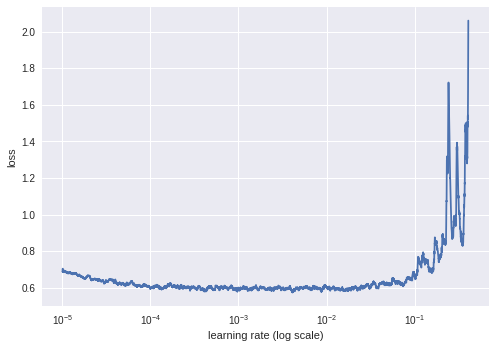

In [259]:
learn.sched.plot()

In [260]:
learn.fit(1e-5, 1, cycle_len=1, wds=wd, use_clr=(10, 3))

  0%|          | 34/15161 [00:04<31:59,  7.88it/s, loss=0.705]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 77/15161 [00:09<30:52,  8.14it/s, loss=0.698]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 115/15161 [00:14<31:03,  8.07it/s, loss=0.693]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 158/15161 [00:19<30:44,  8.13it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 234/15161 [00:29<31:15,  7.96it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 272/15161 [00:34<31:17,  7.93it/s, loss=0.706]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 311/15161 [00:39<31:23,  7.88it/s, loss=0.696]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 349/15161 [00:44<31:16,  7.89it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 390/15161 [00:49<31:10,  7.90it/s, loss=0.699]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 430/15161 [00:54<30:57,  7.93it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 473/15161 [00:59<30:44,  7.96it/s, loss=0.702]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 514/15161 [01:04<30:32,  7.99it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 556/15161 [01:09<30:23,  8.01it/s, loss=0.698]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 640/15161 [01:19<30:02,  8.06it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 678/15161 [01:24<30:01,  8.04it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 757/15161 [01:34<29:53,  8.03it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 799/15161 [01:39<29:46,  8.04it/s, loss=0.691]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 840/15161 [01:44<29:38,  8.05it/s, loss=0.694]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 882/15161 [01:49<29:31,  8.06it/s, loss=0.686]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 923/15161 [01:54<29:22,  8.08it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 965/15161 [01:59<29:16,  8.08it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1043/15161 [02:09<29:11,  8.06it/s, loss=0.688]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1081/15161 [02:14<29:09,  8.05it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1125/15161 [02:19<28:59,  8.07it/s, loss=0.68]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1206/15161 [02:29<28:48,  8.07it/s, loss=0.684]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1247/15161 [02:34<28:41,  8.08it/s, loss=0.686]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1329/15161 [02:44<28:30,  8.09it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1371/15161 [02:49<28:24,  8.09it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1410/15161 [02:54<28:19,  8.09it/s, loss=0.679]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1450/15161 [02:59<28:16,  8.08it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1490/15161 [03:04<28:10,  8.08it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1531/15161 [03:09<28:06,  8.08it/s, loss=0.68]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1615/15161 [03:19<27:53,  8.10it/s, loss=0.674]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1653/15161 [03:24<27:49,  8.09it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1696/15161 [03:29<27:43,  8.10it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1736/15161 [03:34<27:37,  8.10it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1776/15161 [03:39<27:33,  8.10it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1816/15161 [03:44<27:27,  8.10it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1860/15161 [03:49<27:20,  8.11it/s, loss=0.67]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1901/15161 [03:54<27:14,  8.11it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1943/15161 [03:59<27:09,  8.11it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1984/15161 [04:04<27:02,  8.12it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2026/15161 [04:09<26:56,  8.12it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2065/15161 [04:14<26:53,  8.12it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2107/15161 [04:19<26:47,  8.12it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2146/15161 [04:24<26:42,  8.12it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2188/15161 [04:29<26:37,  8.12it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2228/15161 [04:34<26:32,  8.12it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2269/15161 [04:39<26:27,  8.12it/s, loss=0.658]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2304/15161 [04:44<26:26,  8.10it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2347/15161 [04:49<26:20,  8.11it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2387/15161 [04:54<26:15,  8.11it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2428/15161 [04:59<26:10,  8.11it/s, loss=0.66]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2468/15161 [05:04<26:05,  8.11it/s, loss=0.654]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2554/15161 [05:14<25:51,  8.12it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2596/15161 [05:19<25:45,  8.13it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2636/15161 [05:24<25:41,  8.13it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2677/15161 [05:29<25:36,  8.12it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2759/15161 [05:39<25:25,  8.13it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2798/15161 [05:44<25:21,  8.13it/s, loss=0.658]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▊        | 2841/15161 [05:49<25:15,  8.13it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2925/15161 [05:59<25:03,  8.14it/s, loss=0.653]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3004/15161 [06:09<24:55,  8.13it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3045/15161 [06:14<24:49,  8.13it/s, loss=0.657]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3087/15161 [06:19<24:43,  8.14it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3127/15161 [06:24<24:38,  8.14it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3206/15161 [06:34<24:30,  8.13it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3248/15161 [06:39<24:25,  8.13it/s, loss=0.651]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3288/15161 [06:44<24:20,  8.13it/s, loss=0.654]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3330/15161 [06:49<24:14,  8.13it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3369/15161 [06:54<24:10,  8.13it/s, loss=0.65]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3450/15161 [07:04<24:00,  8.13it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3529/15161 [07:14<23:51,  8.13it/s, loss=0.647]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3571/15161 [07:19<23:46,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3611/15161 [07:24<23:41,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3651/15161 [07:29<23:36,  8.12it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3692/15161 [07:34<23:31,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3770/15161 [07:44<23:22,  8.12it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3852/15161 [07:54<23:12,  8.12it/s, loss=0.64]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3931/15161 [08:04<23:03,  8.12it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3973/15161 [08:09<22:58,  8.12it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4012/15161 [08:14<22:53,  8.12it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4052/15161 [08:19<22:49,  8.11it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4135/15161 [08:29<22:38,  8.12it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4176/15161 [08:34<22:33,  8.12it/s, loss=0.644]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4219/15161 [08:39<22:27,  8.12it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4260/15161 [08:44<22:21,  8.12it/s, loss=0.646]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4302/15161 [08:49<22:16,  8.12it/s, loss=0.643]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4386/15161 [08:59<22:05,  8.13it/s, loss=0.646]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4427/15161 [09:04<21:59,  8.13it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4467/15161 [09:09<21:55,  8.13it/s, loss=0.638]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4591/15161 [09:24<21:39,  8.14it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4672/15161 [09:34<21:29,  8.13it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4715/15161 [09:39<21:23,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███▏      | 4755/15161 [09:44<21:18,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4800/15161 [09:49<21:12,  8.14it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4841/15161 [09:54<21:07,  8.15it/s, loss=0.631]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4962/15161 [10:09<20:52,  8.14it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5003/15161 [10:14<20:47,  8.14it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5086/15161 [10:24<20:36,  8.15it/s, loss=0.633]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5129/15161 [10:29<20:31,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5170/15161 [10:34<20:25,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5211/15161 [10:39<20:20,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5251/15161 [10:44<20:15,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5292/15161 [10:49<20:11,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5333/15161 [10:54<20:05,  8.15it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5414/15161 [11:04<19:56,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5454/15161 [11:09<19:51,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5495/15161 [11:14<19:46,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5537/15161 [11:19<19:41,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5578/15161 [11:24<19:35,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5621/15161 [11:29<19:30,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5703/15161 [11:39<19:20,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5781/15161 [11:49<19:11,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5821/15161 [11:54<19:06,  8.15it/s, loss=0.63]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5863/15161 [11:59<19:01,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5904/15161 [12:04<18:55,  8.15it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6025/15161 [12:19<18:41,  8.15it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6109/15161 [12:29<18:30,  8.15it/s, loss=0.631]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6150/15161 [12:34<18:25,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6190/15161 [12:39<18:20,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6233/15161 [12:44<18:14,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6275/15161 [12:49<18:09,  8.15it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6315/15161 [12:54<18:04,  8.16it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6358/15161 [12:59<17:59,  8.16it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6397/15161 [13:04<17:54,  8.16it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6439/15161 [13:09<17:49,  8.16it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6519/15161 [13:19<17:39,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6557/15161 [13:24<17:35,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6596/15161 [13:29<17:31,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6638/15161 [13:34<17:25,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6680/15161 [13:39<17:20,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6720/15161 [13:44<17:15,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6760/15161 [13:49<17:10,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6841/15161 [13:59<17:00,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6882/15161 [14:04<16:55,  8.15it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6923/15161 [14:09<16:50,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6963/15161 [14:14<16:45,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7045/15161 [14:24<16:35,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7086/15161 [14:29<16:30,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7125/15161 [14:34<16:26,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7203/15161 [14:44<16:17,  8.14it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7245/15161 [14:49<16:11,  8.15it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7281/15161 [14:54<16:07,  8.14it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7322/15161 [14:59<16:02,  8.14it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7359/15161 [15:04<15:58,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7444/15161 [15:14<15:47,  8.14it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7528/15161 [15:24<15:37,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7570/15161 [15:29<15:31,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7612/15161 [15:34<15:26,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7653/15161 [15:39<15:21,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7695/15161 [15:44<15:16,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7737/15161 [15:49<15:11,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7778/15161 [15:54<15:05,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7819/15161 [15:59<15:00,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7859/15161 [16:04<14:56,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7900/15161 [16:09<14:51,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7939/15161 [16:14<14:46,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7982/15161 [16:19<14:40,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8021/15161 [16:24<14:36,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8065/15161 [16:29<14:30,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8103/15161 [16:34<14:26,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8225/15161 [16:49<14:11,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8309/15161 [16:59<14:00,  8.15it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8350/15161 [17:04<13:55,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8389/15161 [17:09<13:51,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8470/15161 [17:19<13:41,  8.15it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8511/15161 [17:24<13:36,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8552/15161 [17:29<13:31,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8634/15161 [17:39<13:20,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8673/15161 [17:44<13:16,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8757/15161 [17:54<13:05,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8798/15161 [17:59<13:00,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8841/15161 [18:04<12:55,  8.15it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8882/15161 [18:09<12:50,  8.15it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8922/15161 [18:14<12:45,  8.15it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8963/15161 [18:19<12:40,  8.15it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9003/15161 [18:24<12:35,  8.15it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9046/15161 [18:29<12:29,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9086/15161 [18:34<12:25,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9127/15161 [18:39<12:20,  8.15it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9162/15161 [18:44<12:16,  8.15it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9205/15161 [18:49<12:10,  8.15it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9244/15161 [18:54<12:06,  8.15it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9287/15161 [18:59<12:00,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9328/15161 [19:04<11:55,  8.15it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9371/15161 [19:09<11:50,  8.15it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9456/15161 [19:19<11:39,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9496/15161 [19:24<11:34,  8.16it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9539/15161 [19:29<11:29,  8.16it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9579/15161 [19:34<11:24,  8.16it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9622/15161 [19:39<11:18,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▎   | 9663/15161 [19:44<11:13,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9706/15161 [19:49<11:08,  8.16it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9748/15161 [19:54<11:03,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9911/15161 [20:14<10:43,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9950/15161 [20:19<10:38,  8.16it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9991/15161 [20:24<10:33,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10034/15161 [20:29<10:28,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10074/15161 [20:34<10:23,  8.16it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10114/15161 [20:39<10:18,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10235/15161 [20:54<10:03,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10318/15161 [21:04<09:53,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10359/15161 [21:09<09:48,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10400/15161 [21:14<09:43,  8.16it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10482/15161 [21:24<09:33,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10521/15161 [21:29<09:28,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10560/15161 [21:34<09:23,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10643/15161 [21:44<09:13,  8.16it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10683/15161 [21:49<09:08,  8.16it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10723/15161 [21:54<09:03,  8.16it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10805/15161 [22:04<08:53,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10847/15161 [22:09<08:48,  8.16it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10888/15161 [22:14<08:43,  8.16it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10929/15161 [22:19<08:38,  8.16it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10970/15161 [22:24<08:33,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11013/15161 [22:29<08:28,  8.16it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11053/15161 [22:34<08:23,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11094/15161 [22:39<08:18,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11178/15161 [22:49<08:08,  8.16it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11219/15161 [22:54<08:02,  8.16it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11261/15161 [22:59<07:57,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11303/15161 [23:04<07:52,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11387/15161 [23:14<07:42,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11432/15161 [23:19<07:36,  8.17it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11471/15161 [23:24<07:31,  8.17it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11515/15161 [23:29<07:26,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11598/15161 [23:39<07:16,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11639/15161 [23:44<07:11,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11681/15161 [23:49<07:05,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11765/15161 [23:59<06:55,  8.17it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11807/15161 [24:04<06:50,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11848/15161 [24:09<06:45,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11885/15161 [24:14<06:40,  8.17it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11927/15161 [24:19<06:35,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11964/15161 [24:24<06:31,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12008/15161 [24:29<06:25,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12046/15161 [24:34<06:21,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12089/15161 [24:39<06:15,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12130/15161 [24:44<06:10,  8.17it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12212/15161 [24:54<06:00,  8.17it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12253/15161 [24:59<05:55,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12294/15161 [25:04<05:50,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12377/15161 [25:14<05:40,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12420/15161 [25:19<05:35,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12456/15161 [25:24<05:31,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12497/15161 [25:29<05:26,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12537/15161 [25:34<05:21,  8.17it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▎ | 12662/15161 [25:49<05:05,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12744/15161 [25:59<04:55,  8.17it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12827/15161 [26:09<04:45,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12867/15161 [26:14<04:40,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12908/15161 [26:19<04:35,  8.17it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12947/15161 [26:24<04:30,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12989/15161 [26:29<04:25,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13029/15161 [26:34<04:20,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13070/15161 [26:39<04:15,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13154/15161 [26:49<04:05,  8.17it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13195/15161 [26:54<04:00,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13236/15161 [26:59<03:55,  8.17it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13276/15161 [27:04<03:50,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13320/15161 [27:09<03:45,  8.17it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13360/15161 [27:14<03:40,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13402/15161 [27:19<03:35,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▊ | 13440/15161 [27:24<03:30,  8.17it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13483/15161 [27:29<03:25,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13522/15161 [27:34<03:20,  8.17it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13605/15161 [27:44<03:10,  8.17it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13649/15161 [27:49<03:04,  8.18it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13730/15161 [27:59<02:55,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13771/15161 [28:04<02:50,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████▏| 13852/15161 [28:14<02:40,  8.18it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13894/15161 [28:19<02:34,  8.18it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13973/15161 [28:29<02:25,  8.17it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 14013/15161 [28:34<02:20,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14056/15161 [28:39<02:15,  8.17it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14097/15161 [28:44<02:10,  8.17it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14139/15161 [28:49<02:05,  8.18it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14181/15161 [28:54<01:59,  8.18it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14225/15161 [28:59<01:54,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14265/15161 [29:04<01:49,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14307/15161 [29:09<01:44,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14386/15161 [29:19<01:34,  8.18it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14425/15161 [29:24<01:30,  8.18it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14469/15161 [29:29<01:24,  8.18it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14548/15161 [29:39<01:14,  8.18it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14673/15161 [29:54<00:59,  8.18it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14715/15161 [29:59<00:54,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14755/15161 [30:04<00:49,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14797/15161 [30:09<00:44,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14837/15161 [30:14<00:39,  8.18it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14879/15161 [30:19<00:34,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14918/15161 [30:24<00:29,  8.18it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14959/15161 [30:29<00:24,  8.18it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 14998/15161 [30:34<00:19,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15040/15161 [30:39<00:14,  8.18it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15081/15161 [30:44<00:09,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local

epoch      trn_loss   val_loss   <lambda>   
    0      0.603525   0.589881   0.640506  


[array([0.58988]), 0.640506408591445]

In [261]:
learn.save('clas_lst')

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


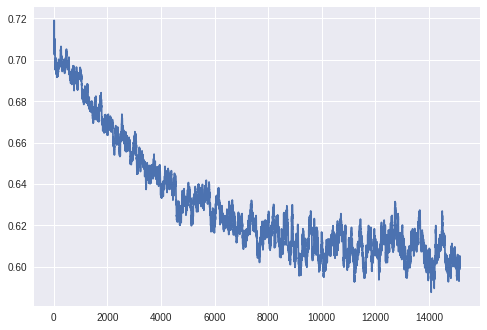

In [262]:
learn.sched.plot_loss()

#### End-to-end

In [0]:
learn.load('clas_lst')

In [0]:
learn.unfreeze()
learn.clip=0.25

In [28]:
wd=1e-9
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

learn.lr_find(lrs/1000, 5, wds=wd)

  0%|          | 28/15161 [00:09<1:29:49,  2.81it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 60/15161 [00:19<1:23:32,  3.01it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 91/15161 [00:29<1:22:28,  3.05it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 122/15161 [00:40<1:22:27,  3.04it/s, loss=0.6]  

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 157/15161 [00:49<1:19:33,  3.14it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 191/15161 [01:00<1:18:27,  3.18it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 225/15161 [01:10<1:17:35,  3.21it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 257/15161 [01:20<1:17:21,  3.21it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 290/15161 [01:30<1:16:59,  3.22it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 324/15161 [01:40<1:16:24,  3.24it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 357/15161 [01:50<1:16:04,  3.24it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 389/15161 [01:59<1:15:53,  3.24it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 421/15161 [02:10<1:15:55,  3.24it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 453/15161 [02:19<1:15:45,  3.24it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 485/15161 [02:29<1:15:38,  3.23it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 519/15161 [02:40<1:15:17,  3.24it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 552/15161 [02:50<1:15:00,  3.25it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 587/15161 [03:00<1:14:33,  3.26it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 620/15161 [03:10<1:14:18,  3.26it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 653/15161 [03:20<1:14:06,  3.26it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 687/15161 [03:30<1:13:45,  3.27it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 719/15161 [03:40<1:13:40,  3.27it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 751/15161 [03:50<1:13:33,  3.26it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 784/15161 [04:00<1:13:22,  3.27it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 817/15161 [04:09<1:13:08,  3.27it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 851/15161 [04:19<1:12:49,  3.28it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 884/15161 [04:30<1:12:41,  3.27it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 918/15161 [04:39<1:12:23,  3.28it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 952/15161 [04:50<1:12:10,  3.28it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 986/15161 [05:00<1:11:54,  3.29it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1019/15161 [05:10<1:11:43,  3.29it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1053/15161 [05:20<1:11:29,  3.29it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1086/15161 [05:29<1:11:16,  3.29it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1118/15161 [05:40<1:11:11,  3.29it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1152/15161 [05:50<1:10:57,  3.29it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1186/15161 [06:00<1:10:43,  3.29it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1218/15161 [06:10<1:10:36,  3.29it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1250/15161 [06:19<1:10:27,  3.29it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1283/15161 [06:29<1:10:17,  3.29it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1316/15161 [06:39<1:10:06,  3.29it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1348/15161 [06:49<1:10:01,  3.29it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1380/15161 [06:59<1:09:52,  3.29it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1414/15161 [07:10<1:09:41,  3.29it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1447/15161 [07:20<1:09:30,  3.29it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1481/15161 [07:30<1:09:17,  3.29it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1514/15161 [07:40<1:09:07,  3.29it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1546/15161 [07:49<1:08:58,  3.29it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1580/15161 [07:59<1:08:45,  3.29it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1612/15161 [08:10<1:08:39,  3.29it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1645/15161 [08:20<1:08:29,  3.29it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1679/15161 [08:30<1:08:16,  3.29it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1710/15161 [08:39<1:08:09,  3.29it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1744/15161 [08:49<1:07:56,  3.29it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1777/15161 [09:00<1:07:47,  3.29it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1810/15161 [09:09<1:07:36,  3.29it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1843/15161 [09:20<1:07:27,  3.29it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1877/15161 [09:30<1:07:15,  3.29it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1910/15161 [09:40<1:07:04,  3.29it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1944/15161 [09:50<1:06:51,  3.29it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1979/15161 [10:00<1:06:37,  3.30it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2012/15161 [10:09<1:06:26,  3.30it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2046/15161 [10:19<1:06:14,  3.30it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2081/15161 [10:30<1:06:00,  3.30it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2109/15161 [10:39<1:06:00,  3.30it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2142/15161 [10:50<1:05:50,  3.30it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2175/15161 [11:00<1:05:40,  3.30it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2239/15161 [11:20<1:05:24,  3.29it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2274/15161 [11:30<1:05:11,  3.29it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2307/15161 [11:39<1:04:59,  3.30it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2377/15161 [12:00<1:04:33,  3.30it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2410/15161 [12:10<1:04:23,  3.30it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2444/15161 [12:20<1:04:11,  3.30it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2477/15161 [12:29<1:04:00,  3.30it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2508/15161 [12:39<1:03:53,  3.30it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2542/15161 [12:50<1:03:43,  3.30it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2574/15161 [12:59<1:03:33,  3.30it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2607/15161 [13:09<1:03:23,  3.30it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2640/15161 [13:20<1:03:15,  3.30it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2672/15161 [13:30<1:03:06,  3.30it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2739/15161 [13:50<1:02:44,  3.30it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2773/15161 [14:00<1:02:33,  3.30it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2804/15161 [14:10<1:02:25,  3.30it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2871/15161 [14:29<1:02:03,  3.30it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2906/15161 [14:39<1:01:51,  3.30it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2938/15161 [14:50<1:01:42,  3.30it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3034/15161 [15:19<1:01:17,  3.30it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3067/15161 [15:29<1:01:06,  3.30it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3099/15161 [15:39<1:00:58,  3.30it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3132/15161 [15:50<1:00:48,  3.30it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3164/15161 [16:00<1:00:41,  3.29it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3198/15161 [16:10<1:00:29,  3.30it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3231/15161 [16:20<1:00:19,  3.30it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3265/15161 [16:30<1:00:07,  3.30it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3297/15161 [16:40<59:58,  3.30it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3331/15161 [16:50<59:47,  3.30it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3366/15161 [17:00<59:34,  3.30it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3400/15161 [17:10<59:23,  3.30it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3465/15161 [17:30<59:04,  3.30it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3501/15161 [17:40<58:50,  3.30it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3535/15161 [17:50<58:39,  3.30it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3569/15161 [18:00<58:28,  3.30it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3602/15161 [18:10<58:18,  3.30it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3669/15161 [18:30<57:57,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3703/15161 [18:40<57:45,  3.31it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3737/15161 [18:50<57:35,  3.31it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3769/15161 [19:00<57:26,  3.31it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3802/15161 [19:10<57:15,  3.31it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3835/15161 [19:20<57:06,  3.31it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3869/15161 [19:30<56:55,  3.31it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3902/15161 [19:40<56:45,  3.31it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3934/15161 [19:50<56:36,  3.31it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3967/15161 [20:00<56:26,  3.31it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4002/15161 [20:10<56:14,  3.31it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4036/15161 [20:20<56:03,  3.31it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4070/15161 [20:30<55:52,  3.31it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4103/15161 [20:40<55:42,  3.31it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4136/15161 [20:50<55:32,  3.31it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4170/15161 [21:00<55:21,  3.31it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4203/15161 [21:10<55:11,  3.31it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4271/15161 [21:30<54:49,  3.31it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4305/15161 [21:40<54:38,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▊       | 4339/15161 [21:50<54:28,  3.31it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4373/15161 [22:00<54:16,  3.31it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4402/15161 [22:10<54:10,  3.31it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4436/15161 [22:19<53:59,  3.31it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4470/15161 [22:30<53:49,  3.31it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4502/15161 [22:40<53:40,  3.31it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4535/15161 [22:50<53:30,  3.31it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4569/15161 [23:00<53:19,  3.31it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4601/15161 [23:10<53:10,  3.31it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4634/15161 [23:20<53:00,  3.31it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4667/15161 [23:30<52:51,  3.31it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4702/15161 [23:40<52:39,  3.31it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4735/15161 [23:50<52:29,  3.31it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███▏      | 4768/15161 [24:00<52:19,  3.31it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4802/15161 [24:10<52:08,  3.31it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4834/15161 [24:20<51:59,  3.31it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4867/15161 [24:30<51:49,  3.31it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4901/15161 [24:40<51:38,  3.31it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4934/15161 [24:50<51:28,  3.31it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4968/15161 [25:00<51:17,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5003/15161 [25:10<51:06,  3.31it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5035/15161 [25:20<50:57,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5068/15161 [25:30<50:47,  3.31it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5101/15161 [25:40<50:37,  3.31it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5135/15161 [25:50<50:26,  3.31it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5170/15161 [26:00<50:14,  3.31it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5204/15161 [26:10<50:04,  3.31it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5235/15161 [26:20<49:56,  3.31it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5268/15161 [26:30<49:46,  3.31it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5302/15161 [26:40<49:35,  3.31it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5334/15161 [26:50<49:26,  3.31it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5367/15161 [27:00<49:16,  3.31it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5400/15161 [27:10<49:06,  3.31it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5435/15161 [27:20<48:55,  3.31it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5470/15161 [27:30<48:43,  3.31it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5503/15161 [27:40<48:33,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5537/15161 [27:50<48:23,  3.32it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5571/15161 [28:00<48:12,  3.32it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5606/15161 [28:10<48:00,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5674/15161 [28:30<47:39,  3.32it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5710/15161 [28:40<47:27,  3.32it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5743/15161 [28:50<47:17,  3.32it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5776/15161 [29:00<47:07,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5809/15161 [29:10<46:57,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5844/15161 [29:20<46:46,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5910/15161 [29:40<46:26,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5943/15161 [29:50<46:16,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5977/15161 [30:00<46:06,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6010/15161 [30:10<45:56,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6079/15161 [30:30<45:34,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6112/15161 [30:40<45:24,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6145/15161 [30:50<45:14,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6179/15161 [31:00<45:04,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6212/15161 [31:10<44:54,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6244/15161 [31:20<44:45,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6278/15161 [31:30<44:34,  3.32it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6311/15161 [31:40<44:24,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6344/15161 [31:50<44:14,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6376/15161 [32:00<44:05,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6410/15161 [32:10<43:55,  3.32it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6439/15161 [32:20<43:48,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6537/15161 [32:50<43:19,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6570/15161 [33:00<43:09,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6604/15161 [33:10<42:58,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6637/15161 [33:20<42:48,  3.32it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6670/15161 [33:30<42:39,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6702/15161 [33:40<42:29,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6734/15161 [33:50<42:20,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6769/15161 [34:00<42:09,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6833/15161 [34:20<41:50,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6866/15161 [34:30<41:41,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6899/15161 [34:40<41:31,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6932/15161 [34:50<41:21,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6966/15161 [35:00<41:10,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6998/15161 [35:10<41:01,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7030/15161 [35:20<40:52,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7063/15161 [35:30<40:42,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7096/15161 [35:40<40:32,  3.32it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7128/15161 [35:50<40:23,  3.31it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7161/15161 [36:00<40:13,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7196/15161 [36:10<40:02,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7230/15161 [36:20<39:51,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7297/15161 [36:40<39:31,  3.32it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7329/15161 [36:50<39:21,  3.32it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7362/15161 [37:00<39:12,  3.32it/s, loss=0.519]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7428/15161 [37:20<38:52,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7461/15161 [37:30<38:42,  3.32it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7494/15161 [37:40<38:32,  3.32it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7526/15161 [37:50<38:23,  3.31it/s, loss=0.526]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7558/15161 [38:00<38:13,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7591/15161 [38:10<38:04,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7624/15161 [38:20<37:54,  3.31it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7657/15161 [38:30<37:44,  3.31it/s, loss=0.517]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7691/15161 [38:40<37:33,  3.31it/s, loss=0.519]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7726/15161 [38:50<37:22,  3.32it/s, loss=0.516]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7758/15161 [39:00<37:13,  3.32it/s, loss=0.501]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7791/15161 [39:10<37:03,  3.31it/s, loss=0.507]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7824/15161 [39:20<36:53,  3.31it/s, loss=0.5]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7857/15161 [39:30<36:43,  3.31it/s, loss=0.506]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7888/15161 [39:40<36:34,  3.31it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7956/15161 [40:00<36:13,  3.31it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7988/15161 [40:10<36:04,  3.31it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8021/15161 [40:20<35:54,  3.31it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8055/15161 [40:30<35:43,  3.31it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8089/15161 [40:40<35:33,  3.31it/s, loss=0.508]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▎    | 8124/15161 [40:50<35:22,  3.32it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8157/15161 [41:00<35:12,  3.32it/s, loss=0.506]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8187/15161 [41:10<35:04,  3.31it/s, loss=0.501]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8221/15161 [41:20<34:53,  3.31it/s, loss=0.51]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8253/15161 [41:30<34:44,  3.31it/s, loss=0.506]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8285/15161 [41:40<34:35,  3.31it/s, loss=0.509]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8319/15161 [41:50<34:24,  3.31it/s, loss=0.51]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8352/15161 [42:00<34:14,  3.31it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8384/15161 [42:10<34:05,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8418/15161 [42:20<33:54,  3.31it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8451/15161 [42:30<33:44,  3.31it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8483/15161 [42:40<33:35,  3.31it/s, loss=0.508]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8516/15161 [42:50<33:25,  3.31it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8550/15161 [43:00<33:15,  3.31it/s, loss=0.519]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8582/15161 [43:10<33:05,  3.31it/s, loss=0.501]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8615/15161 [43:20<32:55,  3.31it/s, loss=0.503]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8649/15161 [43:30<32:45,  3.31it/s, loss=0.513]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8682/15161 [43:40<32:35,  3.31it/s, loss=0.507]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8714/15161 [43:50<32:26,  3.31it/s, loss=0.504]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8746/15161 [44:00<32:16,  3.31it/s, loss=0.5]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8780/15161 [44:10<32:06,  3.31it/s, loss=0.516]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8814/15161 [44:20<31:55,  3.31it/s, loss=0.508]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8846/15161 [44:30<31:46,  3.31it/s, loss=0.503]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8880/15161 [44:40<31:35,  3.31it/s, loss=0.507]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8913/15161 [44:50<31:25,  3.31it/s, loss=0.511]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8946/15161 [45:00<31:15,  3.31it/s, loss=0.517]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9013/15161 [45:20<30:55,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9048/15161 [45:30<30:44,  3.31it/s, loss=0.516]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9114/15161 [45:50<30:24,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9148/15161 [46:00<30:14,  3.31it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9180/15161 [46:10<30:04,  3.31it/s, loss=0.517]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9214/15161 [46:20<29:54,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9245/15161 [46:30<29:45,  3.31it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9279/15161 [46:40<29:35,  3.31it/s, loss=0.516]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9314/15161 [46:50<29:24,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9409/15161 [47:20<28:56,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9442/15161 [47:30<28:46,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9474/15161 [47:40<28:36,  3.31it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9508/15161 [47:50<28:26,  3.31it/s, loss=0.526]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9541/15161 [48:00<28:16,  3.31it/s, loss=0.53]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9573/15161 [48:10<28:07,  3.31it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9606/15161 [48:20<27:57,  3.31it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9674/15161 [48:40<27:36,  3.31it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9707/15161 [48:50<27:26,  3.31it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9741/15161 [49:00<27:16,  3.31it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9773/15161 [49:10<27:06,  3.31it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9807/15161 [49:20<26:56,  3.31it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9840/15161 [49:30<26:46,  3.31it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9874/15161 [49:40<26:35,  3.31it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9902/15161 [49:50<26:28,  3.31it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9968/15161 [50:10<26:08,  3.31it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10036/15161 [50:30<25:47,  3.31it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10067/15161 [50:40<25:38,  3.31it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10101/15161 [50:50<25:28,  3.31it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10133/15161 [51:00<25:18,  3.31it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10166/15161 [51:10<25:08,  3.31it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10199/15161 [51:20<24:58,  3.31it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10232/15161 [51:30<24:48,  3.31it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10265/15161 [51:40<24:38,  3.31it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10298/15161 [51:50<24:28,  3.31it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10364/15161 [52:10<24:08,  3.31it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10397/15161 [52:20<23:58,  3.31it/s, loss=0.655]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10431/15161 [52:30<23:48,  3.31it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10463/15161 [52:40<23:39,  3.31it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10495/15161 [52:50<23:29,  3.31it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10530/15161 [53:00<23:18,  3.31it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10598/15161 [53:20<22:57,  3.31it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10631/15161 [53:30<22:47,  3.31it/s, loss=0.726]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10665/15161 [53:40<22:37,  3.31it/s, loss=0.711]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10700/15161 [53:50<22:26,  3.31it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10732/15161 [54:00<22:17,  3.31it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10766/15161 [54:10<22:06,  3.31it/s, loss=0.725]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10800/15161 [54:20<21:56,  3.31it/s, loss=0.748]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10833/15161 [54:30<21:46,  3.31it/s, loss=0.693]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10899/15161 [54:50<21:26,  3.31it/s, loss=0.655]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10932/15161 [55:00<21:16,  3.31it/s, loss=0.707]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10967/15161 [55:10<21:06,  3.31it/s, loss=0.807]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11000/15161 [55:20<20:55,  3.31it/s, loss=0.815]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11033/15161 [55:30<20:46,  3.31it/s, loss=0.766]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11066/15161 [55:40<20:36,  3.31it/s, loss=0.739]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11100/15161 [55:50<20:25,  3.31it/s, loss=0.792]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11133/15161 [56:00<20:15,  3.31it/s, loss=0.839]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11162/15161 [56:10<20:07,  3.31it/s, loss=0.824]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11195/15161 [56:20<19:57,  3.31it/s, loss=0.799]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11228/15161 [56:30<19:47,  3.31it/s, loss=0.788]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11261/15161 [56:40<19:37,  3.31it/s, loss=0.744]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11294/15161 [56:50<19:27,  3.31it/s, loss=0.852]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11328/15161 [57:00<19:17,  3.31it/s, loss=0.826]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11399/15161 [57:20<18:55,  3.31it/s, loss=0.863]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11431/15161 [57:30<18:45,  3.31it/s, loss=0.98]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11464/15161 [57:40<18:35,  3.31it/s, loss=1.12]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11498/15161 [57:50<18:25,  3.31it/s, loss=1.19]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11532/15161 [58:00<18:15,  3.31it/s, loss=1.19]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11567/15161 [58:10<18:04,  3.31it/s, loss=1.18]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11602/15161 [58:20<17:53,  3.31it/s, loss=1.18]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11646/15161 [58:34<17:40,  3.31it/s, loss=1.97]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


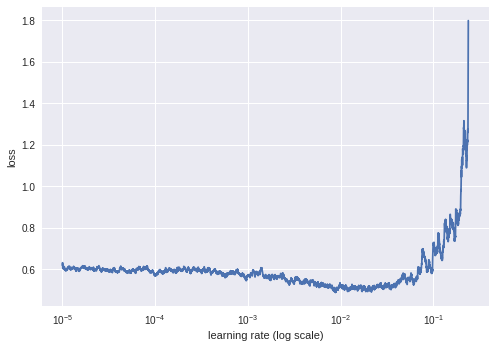

In [29]:
learn.sched.plot()

In [30]:
learn.fit(5e-3, 1, cycle_len=8, wds=wd, use_clr=(30, 10))

  0%|          | 50/15161 [00:14<1:15:10,  3.35it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 84/15161 [00:25<1:14:59,  3.35it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 119/15161 [00:34<1:13:36,  3.41it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 153/15161 [00:45<1:13:38,  3.40it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 186/15161 [00:55<1:13:48,  3.38it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 218/15161 [01:04<1:14:08,  3.36it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 250/15161 [01:15<1:14:33,  3.33it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 280/15161 [01:25<1:15:19,  3.29it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 313/15161 [01:34<1:14:58,  3.30it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 347/15161 [01:44<1:14:38,  3.31it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 410/15161 [02:04<1:14:57,  3.28it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 442/15161 [02:15<1:14:56,  3.27it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 474/15161 [02:24<1:14:46,  3.27it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 508/15161 [02:34<1:14:27,  3.28it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 543/15161 [02:44<1:13:59,  3.29it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 574/15161 [02:54<1:14:03,  3.28it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 610/15161 [03:05<1:13:34,  3.30it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 643/15161 [03:15<1:13:23,  3.30it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 675/15161 [03:25<1:13:20,  3.29it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 708/15161 [03:34<1:13:05,  3.30it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 742/15161 [03:44<1:12:49,  3.30it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 775/15161 [03:54<1:12:41,  3.30it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 808/15161 [04:05<1:12:33,  3.30it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 841/15161 [04:15<1:12:23,  3.30it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 875/15161 [04:25<1:12:06,  3.30it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 909/15161 [04:35<1:11:52,  3.30it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 943/15161 [04:44<1:11:33,  3.31it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 977/15161 [04:54<1:11:21,  3.31it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1010/15161 [05:05<1:11:14,  3.31it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1042/15161 [05:15<1:11:09,  3.31it/s, loss=0.518]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1074/15161 [05:25<1:11:03,  3.30it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1109/15161 [05:35<1:10:45,  3.31it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1141/15161 [05:45<1:10:40,  3.31it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1175/15161 [05:54<1:10:25,  3.31it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1209/15161 [06:05<1:10:12,  3.31it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1243/15161 [06:15<1:09:59,  3.31it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1276/15161 [06:25<1:09:50,  3.31it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1310/15161 [06:34<1:09:35,  3.32it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1344/15161 [06:44<1:09:22,  3.32it/s, loss=0.505]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1378/15161 [06:55<1:09:11,  3.32it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1411/15161 [07:05<1:09:02,  3.32it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1445/15161 [07:14<1:08:48,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1478/15161 [07:25<1:08:40,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1509/15161 [07:34<1:08:35,  3.32it/s, loss=0.516]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1542/15161 [07:45<1:08:27,  3.32it/s, loss=0.518]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1575/15161 [07:54<1:08:16,  3.32it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1606/15161 [08:05<1:08:14,  3.31it/s, loss=0.53]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1639/15161 [08:15<1:08:04,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1673/15161 [08:25<1:07:51,  3.31it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1707/15161 [08:34<1:07:38,  3.32it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1740/15161 [08:44<1:07:29,  3.31it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1807/15161 [09:05<1:07:08,  3.31it/s, loss=0.52]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1840/15161 [09:14<1:06:56,  3.32it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1872/15161 [09:24<1:06:50,  3.31it/s, loss=0.525]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1907/15161 [09:35<1:06:37,  3.32it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1939/15161 [09:45<1:06:29,  3.31it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1971/15161 [09:55<1:06:21,  3.31it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2003/15161 [10:05<1:06:14,  3.31it/s, loss=0.514]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2035/15161 [10:14<1:06:06,  3.31it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2068/15161 [10:24<1:05:56,  3.31it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2136/15161 [10:45<1:05:33,  3.31it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2169/15161 [10:55<1:05:23,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2203/15161 [11:04<1:05:11,  3.31it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2237/15161 [11:15<1:05:00,  3.31it/s, loss=0.506]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2271/15161 [11:24<1:04:47,  3.32it/s, loss=0.519]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2304/15161 [11:35<1:04:38,  3.31it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2338/15161 [11:45<1:04:27,  3.32it/s, loss=0.525]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2368/15161 [11:54<1:04:22,  3.31it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2400/15161 [12:04<1:04:14,  3.31it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2467/15161 [12:25<1:03:54,  3.31it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2498/15161 [12:34<1:03:46,  3.31it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2529/15161 [12:45<1:03:41,  3.31it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2561/15161 [12:54<1:03:32,  3.30it/s, loss=0.51]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2596/15161 [13:05<1:03:20,  3.31it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2662/15161 [13:25<1:03:00,  3.31it/s, loss=0.519]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2729/15161 [13:45<1:02:38,  3.31it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2763/15161 [13:55<1:02:27,  3.31it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2797/15161 [14:05<1:02:15,  3.31it/s, loss=0.522]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▊        | 2829/15161 [14:14<1:02:06,  3.31it/s, loss=0.52]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2864/15161 [14:25<1:01:54,  3.31it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2897/15161 [14:35<1:01:44,  3.31it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2930/15161 [14:45<1:01:34,  3.31it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 2963/15161 [14:55<1:01:25,  3.31it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 2996/15161 [15:04<1:01:14,  3.31it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3031/15161 [15:15<1:01:02,  3.31it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3064/15161 [15:25<1:00:52,  3.31it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3098/15161 [15:35<1:00:41,  3.31it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3131/15161 [15:44<1:00:30,  3.31it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3166/15161 [15:55<1:00:18,  3.31it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3232/15161 [16:15<59:58,  3.31it/s, loss=0.53]  

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3265/15161 [16:24<59:48,  3.31it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3300/15161 [16:35<59:36,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3333/15161 [16:44<59:26,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3368/15161 [16:55<59:14,  3.32it/s, loss=0.515]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3401/15161 [17:05<59:04,  3.32it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3433/15161 [17:15<58:55,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3467/15161 [17:25<58:45,  3.32it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3501/15161 [17:35<58:33,  3.32it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3535/15161 [17:45<58:23,  3.32it/s, loss=0.526]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3569/15161 [17:55<58:12,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3600/15161 [18:05<58:04,  3.32it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3635/15161 [18:15<57:52,  3.32it/s, loss=0.526]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3668/15161 [18:24<57:42,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3702/15161 [18:34<57:30,  3.32it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3735/15161 [18:45<57:22,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3768/15161 [18:55<57:12,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3801/15161 [19:04<57:01,  3.32it/s, loss=0.512]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3835/15161 [19:15<56:51,  3.32it/s, loss=0.523]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3868/15161 [19:25<56:41,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3899/15161 [19:35<56:34,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3931/15161 [19:45<56:25,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3964/15161 [19:54<56:15,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4000/15161 [20:05<56:02,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4033/15161 [20:14<55:52,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4068/15161 [20:25<55:40,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4101/15161 [20:35<55:31,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4134/15161 [20:45<55:21,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4168/15161 [20:54<55:09,  3.32it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4202/15161 [21:05<54:59,  3.32it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4236/15161 [21:15<54:48,  3.32it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4270/15161 [21:25<54:38,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4301/15161 [21:35<54:30,  3.32it/s, loss=0.526]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▊       | 4335/15161 [21:45<54:19,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4370/15161 [21:55<54:07,  3.32it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4404/15161 [22:04<53:56,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4436/15161 [22:15<53:47,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4470/15161 [22:25<53:37,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4536/15161 [22:45<53:17,  3.32it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4569/15161 [22:55<53:07,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4602/15161 [23:05<52:58,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4667/15161 [23:25<52:39,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4700/15161 [23:35<52:29,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4734/15161 [23:45<52:18,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███▏      | 4766/15161 [23:54<52:09,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4799/15161 [24:05<52:00,  3.32it/s, loss=0.527]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4866/15161 [24:25<51:39,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4931/15161 [24:45<51:21,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4998/15161 [25:05<51:00,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5031/15161 [25:15<50:50,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5064/15161 [25:25<50:41,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5097/15161 [25:35<50:31,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5131/15161 [25:45<50:20,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5164/15161 [25:55<50:10,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5197/15161 [26:05<50:00,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5230/15161 [26:15<49:50,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5265/15161 [26:25<49:39,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5298/15161 [26:35<49:29,  3.32it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5330/15161 [26:45<49:20,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5364/15161 [26:55<49:10,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5398/15161 [27:05<48:59,  3.32it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5433/15161 [27:15<48:47,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5465/15161 [27:25<48:38,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5499/15161 [27:35<48:28,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5597/15161 [28:04<47:59,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5633/15161 [28:15<47:47,  3.32it/s, loss=0.528]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5667/15161 [28:25<47:36,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5700/15161 [28:35<47:27,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5733/15161 [28:45<47:16,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5768/15161 [28:55<47:05,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5802/15161 [29:05<46:54,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5836/15161 [29:15<46:44,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5903/15161 [29:35<46:24,  3.33it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5937/15161 [29:45<46:13,  3.33it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5968/15161 [29:55<46:05,  3.32it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6000/15161 [30:05<45:55,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6034/15161 [30:15<45:45,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6068/15161 [30:25<45:34,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6102/15161 [30:35<45:24,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6134/15161 [30:44<45:15,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6168/15161 [30:55<45:04,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6201/15161 [31:05<44:55,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6235/15161 [31:15<44:44,  3.33it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6268/15161 [31:25<44:34,  3.32it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6332/15161 [31:45<44:16,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6363/15161 [31:55<44:08,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6398/15161 [32:05<43:56,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6432/15161 [32:15<43:46,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6465/15161 [32:25<43:36,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6497/15161 [32:35<43:27,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6532/15161 [32:45<43:16,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6598/15161 [33:05<42:56,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6631/15161 [33:15<42:46,  3.32it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6664/15161 [33:25<42:36,  3.32it/s, loss=0.524]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6696/15161 [33:35<42:27,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6727/15161 [33:45<42:19,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6760/15161 [33:55<42:09,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6792/15161 [34:05<42:00,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6825/15161 [34:15<41:50,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6857/15161 [34:25<41:41,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6891/15161 [34:35<41:30,  3.32it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6924/15161 [34:45<41:20,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6956/15161 [34:55<41:11,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6990/15161 [35:05<41:00,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7023/15161 [35:15<40:51,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7084/15161 [35:35<40:34,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7118/15161 [35:45<40:23,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7180/15161 [36:05<40:06,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7216/15161 [36:15<39:55,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7249/15161 [36:25<39:45,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7280/15161 [36:35<39:36,  3.32it/s, loss=0.56] 

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7312/15161 [36:45<39:27,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7376/15161 [37:05<39:08,  3.31it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7410/15161 [37:15<38:58,  3.31it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7443/15161 [37:25<38:48,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7477/15161 [37:35<38:37,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7510/15161 [37:45<38:27,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7545/15161 [37:55<38:16,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7579/15161 [38:05<38:06,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7612/15161 [38:15<37:56,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7647/15161 [38:25<37:45,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7681/15161 [38:35<37:34,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7713/15161 [38:45<37:25,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7746/15161 [38:55<37:15,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7778/15161 [39:05<37:06,  3.32it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7810/15161 [39:15<36:56,  3.32it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7842/15161 [39:25<36:47,  3.32it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7876/15161 [39:35<36:37,  3.32it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7909/15161 [39:45<36:27,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7943/15161 [39:55<36:16,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7977/15161 [40:05<36:06,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8010/15161 [40:15<35:56,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8077/15161 [40:35<35:35,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8107/15161 [40:45<35:27,  3.32it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▎    | 8140/15161 [40:55<35:17,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8174/15161 [41:05<35:07,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8206/15161 [41:15<34:58,  3.31it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8239/15161 [41:25<34:47,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8272/15161 [41:35<34:38,  3.31it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8305/15161 [41:45<34:28,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8338/15161 [41:55<34:18,  3.31it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8373/15161 [42:05<34:07,  3.32it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8407/15161 [42:15<33:56,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8441/15161 [42:25<33:46,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8475/15161 [42:35<33:35,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8508/15161 [42:45<33:26,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8542/15161 [42:55<33:15,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8575/15161 [43:05<33:05,  3.32it/s, loss=0.529]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8607/15161 [43:15<32:56,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8641/15161 [43:25<32:45,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8675/15161 [43:35<32:35,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8707/15161 [43:45<32:25,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8741/15161 [43:55<32:15,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8773/15161 [44:05<32:05,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8808/15161 [44:15<31:55,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8842/15161 [44:25<31:44,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8874/15161 [44:35<31:35,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8908/15161 [44:45<31:25,  3.32it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8941/15161 [44:55<31:15,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8974/15161 [45:05<31:05,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9007/15161 [45:15<30:55,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9040/15161 [45:25<30:45,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9073/15161 [45:35<30:35,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9140/15161 [45:55<30:15,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9174/15161 [46:05<30:04,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9208/15161 [46:15<29:54,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9275/15161 [46:35<29:34,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9308/15161 [46:45<29:24,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9340/15161 [46:55<29:14,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9372/15161 [47:05<29:05,  3.32it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9406/15161 [47:15<28:54,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9441/15161 [47:25<28:43,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9474/15161 [47:35<28:33,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9506/15161 [47:45<28:24,  3.32it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9541/15161 [47:55<28:13,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9576/15161 [48:05<28:02,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9608/15161 [48:15<27:53,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▎   | 9641/15161 [48:25<27:43,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9674/15161 [48:35<27:33,  3.32it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9708/15161 [48:45<27:23,  3.32it/s, loss=0.533]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9774/15161 [49:05<27:03,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9808/15161 [49:15<26:52,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9841/15161 [49:25<26:43,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9874/15161 [49:35<26:33,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9907/15161 [49:45<26:23,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9940/15161 [49:55<26:13,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9974/15161 [50:05<26:03,  3.32it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10008/15161 [50:15<25:52,  3.32it/s, loss=0.521]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10042/15161 [50:25<25:42,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10107/15161 [50:45<25:22,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10139/15161 [50:55<25:13,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10174/15161 [51:05<25:02,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10208/15161 [51:15<24:52,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10241/15161 [51:25<24:42,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10272/15161 [51:35<24:33,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10306/15161 [51:45<24:22,  3.32it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10339/15161 [51:55<24:13,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10371/15161 [52:05<24:03,  3.32it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10405/15161 [52:15<23:53,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10438/15161 [52:25<23:43,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10472/15161 [52:35<23:32,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10504/15161 [52:45<23:23,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10537/15161 [52:55<23:13,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10569/15161 [53:05<23:03,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10603/15161 [53:15<22:53,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10638/15161 [53:25<22:42,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10771/15161 [54:05<22:02,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10806/15161 [54:15<21:51,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10874/15161 [54:35<21:31,  3.32it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10942/15161 [54:55<21:10,  3.32it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10974/15161 [55:05<21:01,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11008/15161 [55:15<20:50,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11040/15161 [55:25<20:41,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11074/15161 [55:35<20:30,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11107/15161 [55:45<20:21,  3.32it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11141/15161 [55:55<20:10,  3.32it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11175/15161 [56:05<20:00,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11209/15161 [56:15<19:50,  3.32it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11243/15161 [56:25<19:39,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11276/15161 [56:35<19:29,  3.32it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11307/15161 [56:45<19:20,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11340/15161 [56:55<19:10,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11373/15161 [57:05<19:00,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11406/15161 [57:15<18:51,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11440/15161 [57:25<18:40,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11473/15161 [57:35<18:30,  3.32it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11505/15161 [57:45<18:21,  3.32it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11539/15161 [57:55<18:10,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11573/15161 [58:05<18:00,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11606/15161 [58:15<17:50,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11637/15161 [58:25<17:41,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11670/15161 [58:35<17:31,  3.32it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11704/15161 [58:45<17:21,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11737/15161 [58:55<17:11,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11769/15161 [59:05<17:01,  3.32it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11803/15161 [59:15<16:51,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11835/15161 [59:25<16:41,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11869/15161 [59:35<16:31,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11902/15161 [59:45<16:21,  3.32it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11936/15161 [59:55<16:11,  3.32it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11971/15161 [1:00:05<16:00,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12005/15161 [1:00:15<15:50,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12037/15161 [1:00:25<15:40,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12071/15161 [1:00:35<15:30,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12105/15161 [1:00:45<15:20,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12139/15161 [1:00:55<15:10,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12172/15161 [1:01:05<15:00,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12205/15161 [1:01:15<14:50,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12237/15161 [1:01:25<14:40,  3.32it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12270/15161 [1:01:35<14:30,  3.32it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████▏ | 12332/15161 [1:01:55<14:12,  3.32it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12365/15161 [1:02:05<14:02,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12397/15161 [1:02:15<13:52,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12430/15161 [1:02:25<13:42,  3.32it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12462/15161 [1:02:35<13:33,  3.32it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12495/15161 [1:02:45<13:23,  3.32it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12529/15161 [1:02:55<13:13,  3.32it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12563/15161 [1:03:05<13:02,  3.32it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12593/15161 [1:03:15<12:53,  3.32it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12627/15161 [1:03:25<12:43,  3.32it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12659/15161 [1:03:35<12:34,  3.32it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▎ | 12694/15161 [1:03:45<12:23,  3.32it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12729/15161 [1:03:55<12:12,  3.32it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12763/15161 [1:04:05<12:02,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12796/15161 [1:04:15<11:52,  3.32it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12830/15161 [1:04:25<11:42,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12862/15161 [1:04:35<11:32,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12896/15161 [1:04:45<11:22,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12932/15161 [1:04:55<11:11,  3.32it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12966/15161 [1:05:05<11:01,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12999/15161 [1:05:15<10:51,  3.32it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13033/15161 [1:05:25<10:40,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13067/15161 [1:05:35<10:30,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13134/15161 [1:05:55<10:10,  3.32it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13166/15161 [1:06:05<10:00,  3.32it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13202/15161 [1:06:15<09:49,  3.32it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13236/15161 [1:06:25<09:39,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13271/15161 [1:06:35<09:29,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13305/15161 [1:06:45<09:18,  3.32it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13337/15161 [1:06:55<09:09,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13370/15161 [1:07:05<08:59,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13402/15161 [1:07:15<08:49,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▊ | 13436/15161 [1:07:25<08:39,  3.32it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13471/15161 [1:07:35<08:28,  3.32it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13504/15161 [1:07:45<08:18,  3.32it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13536/15161 [1:07:55<08:09,  3.32it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13605/15161 [1:08:15<07:48,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13640/15161 [1:08:25<07:37,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13672/15161 [1:08:35<07:28,  3.32it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13705/15161 [1:08:45<07:18,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13739/15161 [1:08:55<07:08,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13774/15161 [1:09:05<06:57,  3.32it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████▏| 13841/15161 [1:09:25<06:37,  3.32it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13874/15161 [1:09:35<06:27,  3.32it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13938/15161 [1:09:55<06:08,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 14004/15161 [1:10:15<05:48,  3.32it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14037/15161 [1:10:25<05:38,  3.32it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14072/15161 [1:10:35<05:27,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14104/15161 [1:10:45<05:18,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14137/15161 [1:10:55<05:08,  3.32it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14202/15161 [1:11:15<04:48,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14235/15161 [1:11:25<04:38,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14265/15161 [1:11:35<04:29,  3.32it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14300/15161 [1:11:45<04:19,  3.32it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14335/15161 [1:11:55<04:08,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14369/15161 [1:12:05<03:58,  3.32it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14434/15161 [1:12:25<03:38,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14467/15161 [1:12:35<03:28,  3.32it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14501/15161 [1:12:45<03:18,  3.32it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14533/15161 [1:12:55<03:09,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14567/15161 [1:13:05<02:58,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▋| 14602/15161 [1:13:15<02:48,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14637/15161 [1:13:25<02:37,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14669/15161 [1:13:35<02:28,  3.32it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14702/15161 [1:13:45<02:18,  3.32it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14735/15161 [1:13:55<02:08,  3.32it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14769/15161 [1:14:05<01:57,  3.32it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14800/15161 [1:14:15<01:48,  3.32it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14833/15161 [1:14:25<01:38,  3.32it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14868/15161 [1:14:35<01:28,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14903/15161 [1:14:45<01:17,  3.32it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14936/15161 [1:14:55<01:07,  3.32it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14967/15161 [1:15:05<00:58,  3.32it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15001/15161 [1:15:15<00:48,  3.32it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15033/15161 [1:15:25<00:38,  3.32it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15064/15161 [1:15:35<00:29,  3.32it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15099/15161 [1:15:45<00:18,  3.32it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15130/15161 [1:15:55<00:09,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local

epoch      trn_loss   val_loss   <lambda>   
    0      0.564722   0.644556   0.676216  
  0%|          | 32/15161 [00:09<1:13:06,  3.45it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 35/15161 [00:10<1:13:08,  3.45it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 64/15161 [00:19<1:15:36,  3.33it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 67/15161 [00:20<1:15:17,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 98/15161 [00:28<1:14:08,  3.39it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 101/15161 [00:30<1:14:52,  3.35it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 132/15161 [00:39<1:14:10,  3.38it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 165/15161 [00:49<1:14:27,  3.36it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 168/15161 [00:50<1:14:24,  3.36it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 198/15161 [00:59<1:14:36,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 201/15161 [01:00<1:14:28,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 230/15161 [01:09<1:14:46,  3.33it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 233/15161 [01:09<1:14:42,  3.33it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 264/15161 [01:19<1:14:37,  3.33it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 266/15161 [01:20<1:14:46,  3.32it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 295/15161 [01:29<1:15:03,  3.30it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 298/15161 [01:30<1:14:54,  3.31it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 328/15161 [01:39<1:14:39,  3.31it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 331/15161 [01:40<1:14:40,  3.31it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 362/15161 [01:49<1:14:30,  3.31it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 364/15161 [01:49<1:14:29,  3.31it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 396/15161 [01:59<1:14:06,  3.32it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 399/15161 [02:00<1:14:02,  3.32it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 430/15161 [02:09<1:13:46,  3.33it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 433/15161 [02:10<1:13:43,  3.33it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 464/15161 [02:19<1:13:26,  3.34it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 467/15161 [02:20<1:13:27,  3.33it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 497/15161 [02:29<1:13:21,  3.33it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 500/15161 [02:30<1:13:20,  3.33it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 529/15161 [02:39<1:13:20,  3.33it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 532/15161 [02:40<1:13:25,  3.32it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 563/15161 [02:49<1:13:06,  3.33it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 566/15161 [02:50<1:13:08,  3.33it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 598/15161 [02:59<1:12:47,  3.33it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 600/15161 [03:00<1:12:52,  3.33it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 630/15161 [03:09<1:12:45,  3.33it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 633/15161 [03:10<1:12:44,  3.33it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 663/15161 [03:19<1:12:34,  3.33it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 667/15161 [03:20<1:12:30,  3.33it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 697/15161 [03:29<1:12:24,  3.33it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 700/15161 [03:30<1:12:23,  3.33it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 730/15161 [03:39<1:12:10,  3.33it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 734/15161 [03:40<1:12:08,  3.33it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 765/15161 [03:49<1:11:55,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 768/15161 [03:50<1:11:53,  3.34it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 799/15161 [03:59<1:11:39,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 802/15161 [04:00<1:11:38,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 834/15161 [04:09<1:11:22,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 837/15161 [04:10<1:11:20,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 867/15161 [04:19<1:11:13,  3.34it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 870/15161 [04:20<1:11:12,  3.35it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 899/15161 [04:29<1:11:12,  3.34it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 902/15161 [04:30<1:11:11,  3.34it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 932/15161 [04:39<1:11:03,  3.34it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 935/15161 [04:40<1:11:02,  3.34it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 967/15161 [04:49<1:10:46,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 970/15161 [04:50<1:10:45,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1001/15161 [04:59<1:10:33,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1004/15161 [05:00<1:10:31,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1038/15161 [05:09<1:10:17,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1069/15161 [05:19<1:10:10,  3.35it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1072/15161 [05:20<1:10:09,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1106/15161 [05:30<1:09:55,  3.35it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1135/15161 [05:39<1:09:50,  3.35it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1138/15161 [05:40<1:09:49,  3.35it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1202/15161 [05:59<1:09:32,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1205/15161 [06:00<1:09:31,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1236/15161 [06:09<1:09:19,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1239/15161 [06:10<1:09:18,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1303/15161 [06:29<1:09:00,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1305/15161 [06:30<1:09:03,  3.34it/s, loss=0.55] 

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1335/15161 [06:39<1:08:53,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1338/15161 [06:40<1:08:53,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1368/15161 [06:49<1:08:46,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1371/15161 [06:50<1:08:46,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1400/15161 [06:59<1:08:41,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1403/15161 [07:00<1:08:40,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1432/15161 [07:09<1:08:34,  3.34it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1435/15161 [07:10<1:08:35,  3.33it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1467/15161 [07:19<1:08:21,  3.34it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1470/15161 [07:19<1:08:17,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1500/15161 [07:29<1:08:11,  3.34it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1503/15161 [07:30<1:08:10,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1535/15161 [07:39<1:07:58,  3.34it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1538/15161 [07:40<1:07:56,  3.34it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1568/15161 [07:49<1:07:48,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1571/15161 [07:50<1:07:46,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1601/15161 [07:59<1:07:40,  3.34it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1604/15161 [07:59<1:07:36,  3.34it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1634/15161 [08:09<1:07:30,  3.34it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1636/15161 [08:09<1:07:30,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1666/15161 [08:19<1:07:24,  3.34it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1668/15161 [08:20<1:07:25,  3.34it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1699/15161 [08:29<1:07:16,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1701/15161 [08:30<1:07:16,  3.33it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1732/15161 [08:39<1:07:06,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1735/15161 [08:40<1:07:04,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1768/15161 [08:49<1:06:50,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1801/15161 [08:59<1:06:40,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1804/15161 [09:00<1:06:39,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1834/15161 [09:09<1:06:31,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1838/15161 [09:10<1:06:28,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1867/15161 [09:19<1:06:22,  3.34it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1870/15161 [09:20<1:06:21,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1902/15161 [09:29<1:06:09,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1904/15161 [09:30<1:06:09,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1937/15161 [09:39<1:05:54,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1940/15161 [09:40<1:05:54,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1970/15161 [09:49<1:05:44,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1973/15161 [09:50<1:05:44,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2003/15161 [09:59<1:05:36,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2006/15161 [10:00<1:05:36,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2040/15161 [10:10<1:05:23,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2071/15161 [10:19<1:05:14,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2103/15161 [10:29<1:05:06,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2106/15161 [10:30<1:05:05,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2141/15161 [10:40<1:04:52,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2171/15161 [10:49<1:04:45,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2174/15161 [10:50<1:04:44,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2203/15161 [10:59<1:04:38,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2206/15161 [11:00<1:04:37,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2236/15161 [11:09<1:04:28,  3.34it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2240/15161 [11:10<1:04:26,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2271/15161 [11:19<1:04:15,  3.34it/s, loss=0.532]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2273/15161 [11:19<1:04:14,  3.34it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2305/15161 [11:29<1:04:05,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2307/15161 [11:30<1:04:05,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2338/15161 [11:39<1:03:55,  3.34it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2341/15161 [11:40<1:03:54,  3.34it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2372/15161 [11:49<1:03:45,  3.34it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2375/15161 [11:50<1:03:42,  3.34it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2404/15161 [11:59<1:03:37,  3.34it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2406/15161 [12:00<1:03:37,  3.34it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2437/15161 [12:09<1:03:27,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2440/15161 [12:10<1:03:26,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2472/15161 [12:19<1:03:15,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2475/15161 [12:20<1:03:14,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2506/15161 [12:29<1:03:03,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2509/15161 [12:30<1:03:02,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2540/15161 [12:39<1:02:53,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2543/15161 [12:40<1:02:51,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2578/15161 [12:50<1:02:39,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2608/15161 [12:59<1:02:30,  3.35it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2611/15161 [13:00<1:02:29,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2641/15161 [13:09<1:02:22,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2643/15161 [13:10<1:02:21,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2673/15161 [13:19<1:02:13,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2676/15161 [13:20<1:02:12,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2708/15161 [13:29<1:02:01,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2711/15161 [13:30<1:02:01,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2741/15161 [13:39<1:01:51,  3.35it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2744/15161 [13:40<1:01:50,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2775/15161 [13:49<1:01:42,  3.35it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2777/15161 [13:50<1:01:41,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▊        | 2809/15161 [13:59<1:01:31,  3.35it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▊        | 2841/15161 [14:09<1:01:22,  3.35it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2844/15161 [14:10<1:01:21,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2875/15161 [14:19<1:01:12,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2878/15161 [14:20<1:01:11,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2909/15161 [14:29<1:01:00,  3.35it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2912/15161 [14:30<1:01:00,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2943/15161 [14:39<1:00:51,  3.35it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2946/15161 [14:40<1:00:49,  3.35it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 2981/15161 [14:50<1:00:36,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3012/15161 [14:59<1:00:27,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3015/15161 [15:00<1:00:26,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3044/15161 [15:09<1:00:20,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3047/15161 [15:10<1:00:19,  3.35it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3078/15161 [15:19<1:00:08,  3.35it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3081/15161 [15:20<1:00:07,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3115/15161 [15:30<59:57,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3145/15161 [15:39<59:49,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3148/15161 [15:40<59:48,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3180/15161 [15:49<59:37,  3.35it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3182/15161 [15:50<59:37,  3.35it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3212/15161 [15:59<59:28,  3.35it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3247/15161 [16:09<59:16,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3250/15161 [16:10<59:15,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3280/15161 [16:19<59:07,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3283/15161 [16:20<59:06,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3312/15161 [16:29<58:58,  3.35it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3315/15161 [16:30<58:58,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3346/15161 [16:39<58:48,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3349/15161 [16:40<58:47,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3379/15161 [16:49<58:39,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3382/15161 [16:50<58:38,  3.35it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3413/15161 [16:59<58:29,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3415/15161 [17:00<58:28,  3.35it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3445/15161 [17:09<58:20,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3448/15161 [17:10<58:19,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3482/15161 [17:20<58:09,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3513/15161 [17:29<57:59,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3516/15161 [17:30<57:57,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3547/15161 [17:39<57:48,  3.35it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3550/15161 [17:40<57:47,  3.35it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3581/15161 [17:49<57:38,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3584/15161 [17:50<57:37,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3615/15161 [17:59<57:27,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3618/15161 [18:00<57:26,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3650/15161 [18:09<57:15,  3.35it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3653/15161 [18:10<57:14,  3.35it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3685/15161 [18:20<57:06,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3713/15161 [18:29<57:00,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3716/15161 [18:30<56:59,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3744/15161 [18:39<56:53,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3747/15161 [18:40<56:52,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3778/15161 [18:49<56:42,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3815/15161 [18:59<56:28,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3816/15161 [19:00<56:29,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3847/15161 [19:09<56:20,  3.35it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3850/15161 [19:10<56:19,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3880/15161 [19:19<56:10,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3883/15161 [19:20<56:09,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3913/15161 [19:29<56:00,  3.35it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3916/15161 [19:30<56:00,  3.35it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3946/15161 [19:39<55:51,  3.35it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3948/15161 [19:40<55:51,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 3981/15161 [19:49<55:40,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 3984/15161 [19:50<55:39,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4013/15161 [19:59<55:31,  3.35it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4015/15161 [20:00<55:31,  3.35it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4047/15161 [20:10<55:23,  3.34it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4077/15161 [20:19<55:14,  3.34it/s, loss=0.536]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4080/15161 [20:20<55:14,  3.34it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4112/15161 [20:29<55:03,  3.34it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4115/15161 [20:30<55:02,  3.34it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4146/15161 [20:39<54:52,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4149/15161 [20:40<54:51,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4181/15161 [20:49<54:41,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4183/15161 [20:50<54:40,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4215/15161 [20:59<54:30,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4218/15161 [21:00<54:29,  3.35it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4249/15161 [21:09<54:20,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4251/15161 [21:10<54:19,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4283/15161 [21:19<54:09,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4286/15161 [21:20<54:08,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4316/15161 [21:29<53:59,  3.35it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4319/15161 [21:30<53:58,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▊       | 4350/15161 [21:39<53:49,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▊       | 4353/15161 [21:40<53:48,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4385/15161 [21:49<53:37,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4388/15161 [21:50<53:36,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4418/15161 [21:59<53:27,  3.35it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4421/15161 [22:00<53:27,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4452/15161 [22:09<53:17,  3.35it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4455/15161 [22:10<53:16,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4483/15161 [22:19<53:10,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4517/15161 [22:29<53:00,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4519/15161 [22:30<53:00,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4552/15161 [22:39<52:48,  3.35it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4584/15161 [22:49<52:39,  3.35it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4587/15161 [22:50<52:38,  3.35it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4618/15161 [22:59<52:29,  3.35it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4621/15161 [23:00<52:28,  3.35it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4651/15161 [23:09<52:19,  3.35it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4654/15161 [23:10<52:18,  3.35it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4687/15161 [23:19<52:07,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4719/15161 [23:29<51:58,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4722/15161 [23:30<51:57,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███▏      | 4750/15161 [23:39<51:50,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4782/15161 [23:49<51:42,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4785/15161 [23:50<51:41,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4818/15161 [24:00<51:32,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4849/15161 [24:09<51:22,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4882/15161 [24:19<51:12,  3.35it/s, loss=0.53]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4885/15161 [24:20<51:11,  3.35it/s, loss=0.53]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4915/15161 [24:29<51:03,  3.34it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4918/15161 [24:30<51:02,  3.34it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4952/15161 [24:40<50:51,  3.35it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4984/15161 [24:49<50:41,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4987/15161 [24:50<50:40,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5016/15161 [24:59<50:32,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5019/15161 [25:00<50:31,  3.35it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5048/15161 [25:09<50:23,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5051/15161 [25:10<50:22,  3.34it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5081/15161 [25:19<50:14,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5115/15161 [25:29<50:04,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5118/15161 [25:30<50:02,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5148/15161 [25:39<49:54,  3.34it/s, loss=0.531]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5151/15161 [25:40<49:53,  3.34it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5183/15161 [25:49<49:42,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5186/15161 [25:50<49:41,  3.35it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5215/15161 [25:59<49:34,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5218/15161 [26:00<49:33,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5250/15161 [26:09<49:22,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5252/15161 [26:10<49:22,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5283/15161 [26:19<49:13,  3.34it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5285/15161 [26:20<49:12,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5316/15161 [26:29<49:03,  3.34it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5318/15161 [26:30<49:03,  3.34it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5350/15161 [26:39<48:53,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5385/15161 [26:49<48:41,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5388/15161 [26:50<48:41,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5419/15161 [26:59<48:31,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5421/15161 [27:00<48:31,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5451/15161 [27:09<48:22,  3.35it/s, loss=0.538]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5485/15161 [27:19<48:12,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5488/15161 [27:20<48:11,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5519/15161 [27:29<48:01,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5522/15161 [27:30<48:00,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5553/15161 [27:39<47:51,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5555/15161 [27:40<47:50,  3.35it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5586/15161 [27:49<47:41,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5589/15161 [27:50<47:40,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5619/15161 [27:59<47:31,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5623/15161 [28:00<47:30,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5652/15161 [28:09<47:22,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5655/15161 [28:10<47:21,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5686/15161 [28:19<47:11,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5689/15161 [28:20<47:10,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5720/15161 [28:29<47:01,  3.35it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5754/15161 [28:39<46:51,  3.35it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5757/15161 [28:40<46:50,  3.35it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5788/15161 [28:49<46:40,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5790/15161 [28:50<46:40,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5820/15161 [28:59<46:31,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5823/15161 [29:00<46:30,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5854/15161 [29:09<46:21,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5857/15161 [29:10<46:20,  3.35it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5887/15161 [29:19<46:11,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5890/15161 [29:20<46:10,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5922/15161 [29:29<46:00,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5924/15161 [29:30<46:00,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5955/15161 [29:39<45:50,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5958/15161 [29:40<45:50,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 5989/15161 [29:49<45:40,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 5991/15161 [29:50<45:40,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6022/15161 [29:59<45:30,  3.35it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6025/15161 [30:00<45:29,  3.35it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6054/15161 [30:09<45:22,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6056/15161 [30:10<45:21,  3.35it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6087/15161 [30:19<45:12,  3.35it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6090/15161 [30:20<45:11,  3.35it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6121/15161 [30:29<45:01,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6124/15161 [30:30<45:00,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6154/15161 [30:39<44:52,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6156/15161 [30:40<44:52,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6185/15161 [30:49<44:44,  3.34it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6188/15161 [30:50<44:43,  3.34it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6221/15161 [31:00<44:33,  3.34it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6252/15161 [31:09<44:23,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6254/15161 [31:10<44:23,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6285/15161 [31:19<44:14,  3.34it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6288/15161 [31:20<44:13,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6319/15161 [31:29<44:03,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6322/15161 [31:30<44:02,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6352/15161 [31:39<43:54,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6355/15161 [31:40<43:53,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6386/15161 [31:49<43:43,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6388/15161 [31:50<43:43,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6419/15161 [31:59<43:34,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6421/15161 [32:00<43:33,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6452/15161 [32:09<43:24,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6455/15161 [32:10<43:23,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6487/15161 [32:19<43:13,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6490/15161 [32:20<43:12,  3.34it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6521/15161 [32:29<43:02,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6525/15161 [32:30<43:01,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6559/15161 [32:40<42:50,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6590/15161 [32:49<42:41,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6593/15161 [32:50<42:40,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6624/15161 [32:59<42:31,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6628/15161 [33:00<42:29,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6658/15161 [33:09<42:20,  3.35it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6661/15161 [33:10<42:19,  3.35it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6693/15161 [33:19<42:09,  3.35it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6695/15161 [33:20<42:09,  3.35it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6727/15161 [33:29<41:59,  3.35it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6730/15161 [33:30<41:58,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6759/15161 [33:39<41:50,  3.35it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6762/15161 [33:40<41:49,  3.35it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6792/15161 [33:49<41:40,  3.35it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6795/15161 [33:50<41:39,  3.35it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6825/15161 [33:59<41:31,  3.35it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6828/15161 [34:00<41:30,  3.35it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6862/15161 [34:10<41:19,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6894/15161 [34:19<41:09,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6897/15161 [34:20<41:08,  3.35it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6927/15161 [34:29<41:00,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6930/15161 [34:30<40:58,  3.35it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6961/15161 [34:39<40:49,  3.35it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6964/15161 [34:40<40:48,  3.35it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6996/15161 [34:49<40:38,  3.35it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6998/15161 [34:50<40:38,  3.35it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7031/15161 [35:00<40:28,  3.35it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7062/15161 [35:09<40:19,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7065/15161 [35:10<40:18,  3.35it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7096/15161 [35:20<40:09,  3.35it/s, loss=0.542]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7125/15161 [35:29<40:01,  3.35it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7129/15161 [35:30<40:00,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7160/15161 [35:39<39:50,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7163/15161 [35:40<39:49,  3.35it/s, loss=0.552]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7195/15161 [35:49<39:39,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7197/15161 [35:50<39:39,  3.35it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7228/15161 [35:59<39:30,  3.35it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7231/15161 [36:00<39:29,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7259/15161 [36:09<39:21,  3.35it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7262/15161 [36:10<39:20,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7293/15161 [36:19<39:11,  3.35it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7296/15161 [36:20<39:10,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7326/15161 [36:29<39:01,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7329/15161 [36:30<39:00,  3.35it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7361/15161 [36:39<38:50,  3.35it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7364/15161 [36:40<38:49,  3.35it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7395/15161 [36:49<38:40,  3.35it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7398/15161 [36:50<38:39,  3.35it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7428/15161 [36:59<38:30,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7431/15161 [37:00<38:29,  3.35it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7461/15161 [37:09<38:21,  3.35it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7464/15161 [37:10<38:19,  3.35it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7495/15161 [37:19<38:10,  3.35it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7498/15161 [37:20<38:09,  3.35it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7529/15161 [37:29<38:00,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7532/15161 [37:30<37:59,  3.35it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7562/15161 [37:39<37:50,  3.35it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7565/15161 [37:40<37:49,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7595/15161 [37:49<37:40,  3.35it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7598/15161 [37:50<37:39,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7629/15161 [37:59<37:30,  3.35it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7632/15161 [38:00<37:29,  3.35it/s, loss=0.537]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7662/15161 [38:09<37:20,  3.35it/s, loss=0.54]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7665/15161 [38:10<37:19,  3.35it/s, loss=0.539]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7696/15161 [38:19<37:10,  3.35it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7699/15161 [38:20<37:09,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7729/15161 [38:29<37:00,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7732/15161 [38:30<36:59,  3.35it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7762/15161 [38:39<36:51,  3.35it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7795/15161 [38:49<36:41,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7798/15161 [38:50<36:40,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7828/15161 [38:59<36:31,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7831/15161 [39:00<36:30,  3.35it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7861/15161 [39:09<36:22,  3.35it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7864/15161 [39:10<36:21,  3.35it/s, loss=0.534]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7894/15161 [39:19<36:12,  3.35it/s, loss=0.535]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7897/15161 [39:20<36:11,  3.35it/s, loss=0.541]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7927/15161 [39:29<36:02,  3.35it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7930/15161 [39:30<36:01,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7960/15161 [39:39<35:52,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7964/15161 [39:40<35:51,  3.35it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7995/15161 [39:49<35:41,  3.35it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7998/15161 [39:50<35:40,  3.35it/s, loss=0.544]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8027/15161 [39:59<35:32,  3.35it/s, loss=0.547]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8060/15161 [40:09<35:22,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8093/15161 [40:19<35:13,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8096/15161 [40:20<35:12,  3.34it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▎    | 8127/15161 [40:29<35:02,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▎    | 8129/15161 [40:30<35:02,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8159/15161 [40:39<34:53,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8162/15161 [40:40<34:52,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8191/15161 [40:49<34:44,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8193/15161 [40:50<34:43,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8224/15161 [40:59<34:34,  3.34it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8256/15161 [41:09<34:25,  3.34it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8259/15161 [41:10<34:24,  3.34it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8290/15161 [41:19<34:15,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8293/15161 [41:20<34:14,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8324/15161 [41:29<34:04,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8327/15161 [41:30<34:03,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8356/15161 [41:39<33:55,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8359/15161 [41:40<33:54,  3.34it/s, loss=0.551]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8389/15161 [41:49<33:45,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8391/15161 [41:50<33:45,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8421/15161 [41:59<33:36,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8423/15161 [42:00<33:36,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8451/15161 [42:09<33:28,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8454/15161 [42:10<33:27,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8485/15161 [42:19<33:18,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8488/15161 [42:20<33:17,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8520/15161 [42:29<33:07,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8523/15161 [42:30<33:06,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8551/15161 [42:39<32:58,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8554/15161 [42:40<32:57,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8581/15161 [42:49<32:50,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8584/15161 [42:50<32:49,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8616/15161 [42:59<32:39,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8649/15161 [43:09<32:29,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8652/15161 [43:10<32:28,  3.34it/s, loss=0.545]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8683/15161 [43:19<32:19,  3.34it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8685/15161 [43:20<32:19,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8715/15161 [43:29<32:10,  3.34it/s, loss=0.546]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8718/15161 [43:30<32:09,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8748/15161 [43:39<32:00,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8751/15161 [43:40<31:59,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8782/15161 [43:49<31:50,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8784/15161 [43:50<31:49,  3.34it/s, loss=0.55]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8816/15161 [43:59<31:39,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8818/15161 [44:00<31:39,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8850/15161 [44:09<31:29,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8853/15161 [44:10<31:28,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8885/15161 [44:20<31:19,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8916/15161 [44:29<31:09,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8919/15161 [44:30<31:09,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8949/15161 [44:39<31:00,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8952/15161 [44:40<30:59,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8982/15161 [44:49<30:50,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8985/15161 [44:50<30:49,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9016/15161 [44:59<30:40,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9019/15161 [45:00<30:39,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9050/15161 [45:09<30:29,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9053/15161 [45:10<30:28,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9083/15161 [45:19<30:19,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9086/15161 [45:20<30:18,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9116/15161 [45:29<30:10,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9119/15161 [45:30<30:09,  3.34it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9150/15161 [45:39<29:59,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9152/15161 [45:40<29:59,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9181/15161 [45:49<29:50,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9184/15161 [45:50<29:50,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9214/15161 [45:59<29:41,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9217/15161 [46:00<29:40,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9247/15161 [46:09<29:31,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9251/15161 [46:10<29:30,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9280/15161 [46:19<29:21,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9283/15161 [46:20<29:20,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9310/15161 [46:29<29:13,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9312/15161 [46:30<29:12,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9344/15161 [46:39<29:02,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9346/15161 [46:40<29:02,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9378/15161 [46:49<28:52,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9380/15161 [46:50<28:52,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9410/15161 [46:59<28:43,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9412/15161 [47:00<28:42,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9442/15161 [47:09<28:33,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9444/15161 [47:10<28:33,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9478/15161 [47:20<28:23,  3.34it/s, loss=0.543]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9510/15161 [47:29<28:13,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9512/15161 [47:30<28:12,  3.34it/s, loss=0.549]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9542/15161 [47:39<28:03,  3.34it/s, loss=0.548]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9574/15161 [47:49<27:54,  3.34it/s, loss=0.554]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9577/15161 [47:50<27:53,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9607/15161 [47:59<27:44,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9610/15161 [48:00<27:43,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▎   | 9641/15161 [48:09<27:34,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▎   | 9644/15161 [48:10<27:33,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9674/15161 [48:19<27:24,  3.34it/s, loss=0.558]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9677/15161 [48:20<27:23,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9709/15161 [48:29<27:13,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9712/15161 [48:30<27:12,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9746/15161 [48:40<27:02,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9778/15161 [48:49<26:52,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9781/15161 [48:50<26:51,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9811/15161 [48:59<26:43,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9814/15161 [49:00<26:42,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9844/15161 [49:09<26:33,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9846/15161 [49:10<26:32,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9877/15161 [49:19<26:23,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9880/15161 [49:20<26:22,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9911/15161 [49:29<26:13,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9914/15161 [49:30<26:12,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9943/15161 [49:39<26:03,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9946/15161 [49:40<26:02,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9976/15161 [49:49<25:53,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9979/15161 [49:50<25:52,  3.34it/s, loss=0.553]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10008/15161 [49:59<25:44,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10043/15161 [50:09<25:33,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10046/15161 [50:10<25:32,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10077/15161 [50:19<25:23,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10079/15161 [50:20<25:23,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10109/15161 [50:29<25:14,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10112/15161 [50:30<25:13,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10142/15161 [50:39<25:04,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10175/15161 [50:49<24:54,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10178/15161 [50:50<24:53,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10208/15161 [50:59<24:44,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10210/15161 [51:00<24:44,  3.34it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10241/15161 [51:09<24:34,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10244/15161 [51:10<24:33,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10273/15161 [51:19<24:25,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10276/15161 [51:20<24:24,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10308/15161 [51:29<24:14,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10311/15161 [51:30<24:13,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10341/15161 [51:39<24:04,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10344/15161 [51:40<24:03,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10374/15161 [51:49<23:54,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10377/15161 [51:50<23:54,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10407/15161 [51:59<23:45,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10410/15161 [52:00<23:44,  3.34it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10440/15161 [52:09<23:35,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10443/15161 [52:10<23:34,  3.34it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10472/15161 [52:19<23:25,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10475/15161 [52:20<23:24,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10506/15161 [52:29<23:15,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10539/15161 [52:39<23:05,  3.34it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10541/15161 [52:40<23:05,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10572/15161 [52:49<22:55,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10575/15161 [52:50<22:54,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10605/15161 [52:59<22:46,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10608/15161 [53:00<22:45,  3.34it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10639/15161 [53:09<22:35,  3.34it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10641/15161 [53:10<22:35,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10672/15161 [53:19<22:25,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10675/15161 [53:20<22:24,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10707/15161 [53:30<22:15,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10738/15161 [53:39<22:06,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10741/15161 [53:40<22:05,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10772/15161 [53:49<21:55,  3.34it/s, loss=0.566]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10775/15161 [53:50<21:54,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10805/15161 [53:59<21:46,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10808/15161 [54:00<21:45,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10839/15161 [54:09<21:35,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10842/15161 [54:10<21:34,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10874/15161 [54:19<21:25,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10877/15161 [54:20<21:24,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10906/15161 [54:29<21:15,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10940/15161 [54:39<21:05,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10942/15161 [54:40<21:04,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10972/15161 [54:49<20:55,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10975/15161 [54:50<20:55,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11005/15161 [54:59<20:46,  3.34it/s, loss=0.561]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11008/15161 [55:00<20:45,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11039/15161 [55:09<20:35,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11041/15161 [55:10<20:35,  3.34it/s, loss=0.557]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11073/15161 [55:19<20:25,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11075/15161 [55:20<20:25,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11107/15161 [55:29<20:15,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11110/15161 [55:30<20:14,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11141/15161 [55:39<20:05,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11143/15161 [55:40<20:04,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11173/15161 [55:49<19:55,  3.34it/s, loss=0.555]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11175/15161 [55:50<19:55,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11207/15161 [55:59<19:45,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11210/15161 [56:00<19:44,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11241/15161 [56:09<19:35,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11244/15161 [56:10<19:34,  3.34it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11277/15161 [56:19<19:24,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11279/15161 [56:20<19:23,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11311/15161 [56:29<19:13,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11314/15161 [56:30<19:12,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11348/15161 [56:40<19:02,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11380/15161 [56:49<18:52,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11383/15161 [56:50<18:51,  3.34it/s, loss=0.565]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11414/15161 [56:59<18:42,  3.34it/s, loss=0.567]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11416/15161 [57:00<18:42,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11446/15161 [57:09<18:33,  3.34it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11449/15161 [57:10<18:32,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11480/15161 [57:19<18:22,  3.34it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11482/15161 [57:20<18:22,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11514/15161 [57:29<18:12,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11516/15161 [57:30<18:12,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11544/15161 [57:39<18:04,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11547/15161 [57:40<18:03,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11576/15161 [57:49<17:54,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11578/15161 [57:50<17:53,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11609/15161 [57:59<17:44,  3.34it/s, loss=0.559]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11611/15161 [58:00<17:44,  3.34it/s, loss=0.56]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11641/15161 [58:09<17:35,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11644/15161 [58:10<17:34,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11675/15161 [58:19<17:24,  3.34it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11678/15161 [58:20<17:24,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11707/15161 [58:29<17:15,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11710/15161 [58:30<17:14,  3.34it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11741/15161 [58:39<17:05,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11744/15161 [58:40<17:04,  3.34it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11775/15161 [58:49<16:55,  3.34it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11778/15161 [58:50<16:54,  3.34it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11809/15161 [58:59<16:44,  3.34it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11812/15161 [59:00<16:43,  3.34it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11839/15161 [59:09<16:36,  3.34it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11841/15161 [59:10<16:35,  3.34it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11874/15161 [59:19<16:25,  3.34it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11877/15161 [59:20<16:24,  3.34it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11910/15161 [59:29<16:14,  3.34it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11912/15161 [59:30<16:13,  3.34it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11942/15161 [59:39<16:04,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11945/15161 [59:40<16:04,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11976/15161 [59:49<15:54,  3.34it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11979/15161 [59:50<15:53,  3.34it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12009/15161 [59:59<15:44,  3.34it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12011/15161 [1:00:00<15:44,  3.34it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12044/15161 [1:00:09<15:34,  3.34it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12045/15161 [1:00:10<15:34,  3.34it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12076/15161 [1:00:19<15:24,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12079/15161 [1:00:20<15:23,  3.34it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12111/15161 [1:00:29<15:14,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12113/15161 [1:00:30<15:13,  3.34it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12146/15161 [1:00:40<15:03,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12176/15161 [1:00:49<14:54,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12179/15161 [1:00:50<14:53,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12210/15161 [1:00:59<14:44,  3.34it/s, loss=0.571]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12213/15161 [1:01:00<14:43,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12242/15161 [1:01:09<14:35,  3.34it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12245/15161 [1:01:10<14:34,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12277/15161 [1:01:19<14:24,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12279/15161 [1:01:20<14:23,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12309/15161 [1:01:29<14:14,  3.34it/s, loss=0.556]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12312/15161 [1:01:30<14:14,  3.34it/s, loss=0.564]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████▏ | 12342/15161 [1:01:39<14:05,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████▏ | 12345/15161 [1:01:40<14:04,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12377/15161 [1:01:49<13:54,  3.34it/s, loss=0.563]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12379/15161 [1:01:50<13:53,  3.34it/s, loss=0.562]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12411/15161 [1:01:59<13:44,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12413/15161 [1:02:00<13:43,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12443/15161 [1:02:09<13:34,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12477/15161 [1:02:19<13:24,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12479/15161 [1:02:20<13:23,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12510/15161 [1:02:29<13:14,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12512/15161 [1:02:30<13:14,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12543/15161 [1:02:39<13:04,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12546/15161 [1:02:40<13:03,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12575/15161 [1:02:49<12:55,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12578/15161 [1:02:50<12:54,  3.34it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12607/15161 [1:02:59<12:45,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12609/15161 [1:03:00<12:45,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12639/15161 [1:03:09<12:36,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12642/15161 [1:03:10<12:35,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▎ | 12672/15161 [1:03:19<12:26,  3.33it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▎ | 12674/15161 [1:03:20<12:25,  3.33it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12705/15161 [1:03:29<12:16,  3.33it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12708/15161 [1:03:30<12:15,  3.33it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12738/15161 [1:03:39<12:06,  3.33it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12740/15161 [1:03:40<12:05,  3.33it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12770/15161 [1:03:49<11:57,  3.33it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12773/15161 [1:03:50<11:56,  3.33it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12805/15161 [1:03:59<11:46,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12808/15161 [1:04:00<11:45,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12839/15161 [1:04:09<11:36,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12842/15161 [1:04:10<11:35,  3.34it/s, loss=0.57]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12874/15161 [1:04:19<11:25,  3.34it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12877/15161 [1:04:20<11:24,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12912/15161 [1:04:30<11:14,  3.34it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12943/15161 [1:04:39<11:04,  3.34it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12946/15161 [1:04:40<11:03,  3.34it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12976/15161 [1:04:49<10:55,  3.34it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12979/15161 [1:04:50<10:54,  3.34it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13008/15161 [1:04:59<10:45,  3.34it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13011/15161 [1:05:00<10:44,  3.34it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13042/15161 [1:05:09<10:35,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13074/15161 [1:05:19<10:25,  3.34it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▋ | 13077/15161 [1:05:20<10:24,  3.34it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▋ | 13109/15161 [1:05:29<10:15,  3.34it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▋ | 13111/15161 [1:05:30<10:14,  3.34it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13142/15161 [1:05:39<10:05,  3.34it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13145/15161 [1:05:40<10:04,  3.34it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13176/15161 [1:05:49<09:55,  3.34it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13211/15161 [1:06:00<09:44,  3.34it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13241/15161 [1:06:09<09:35,  3.34it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13275/15161 [1:06:19<09:25,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13278/15161 [1:06:20<09:24,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13310/15161 [1:06:29<09:14,  3.34it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13312/15161 [1:06:30<09:14,  3.34it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13342/15161 [1:06:39<09:05,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13344/15161 [1:06:40<09:04,  3.34it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13376/15161 [1:06:49<08:55,  3.34it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13379/15161 [1:06:50<08:54,  3.34it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13410/15161 [1:06:59<08:44,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13413/15161 [1:07:00<08:43,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▊ | 13445/15161 [1:07:09<08:34,  3.34it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▊ | 13447/15161 [1:07:10<08:33,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13478/15161 [1:07:19<08:24,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13479/15161 [1:07:20<08:24,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13506/15161 [1:07:29<08:16,  3.33it/s, loss=0.577]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13509/15161 [1:07:30<08:15,  3.34it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13540/15161 [1:07:39<08:06,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13543/15161 [1:07:40<08:05,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13575/15161 [1:07:49<07:55,  3.34it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13578/15161 [1:07:50<07:54,  3.34it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13607/15161 [1:07:59<07:45,  3.34it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13610/15161 [1:08:00<07:45,  3.34it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13639/15161 [1:08:09<07:36,  3.33it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13641/15161 [1:08:10<07:35,  3.33it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13673/15161 [1:08:19<07:26,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13676/15161 [1:08:20<07:25,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13707/15161 [1:08:29<07:15,  3.34it/s, loss=0.578]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13710/15161 [1:08:30<07:15,  3.34it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13741/15161 [1:08:39<07:05,  3.34it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13743/15161 [1:08:40<07:05,  3.34it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13773/15161 [1:08:49<06:56,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13776/15161 [1:08:50<06:55,  3.34it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13807/15161 [1:08:59<06:45,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13809/15161 [1:09:00<06:45,  3.34it/s, loss=0.568]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████▏| 13838/15161 [1:09:09<06:36,  3.33it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████▏| 13841/15161 [1:09:10<06:35,  3.33it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13873/15161 [1:09:19<06:26,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13876/15161 [1:09:20<06:25,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13907/15161 [1:09:29<06:15,  3.34it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13910/15161 [1:09:30<06:15,  3.34it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13940/15161 [1:09:39<06:06,  3.34it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13943/15161 [1:09:40<06:05,  3.34it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13973/15161 [1:09:49<05:56,  3.33it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13976/15161 [1:09:50<05:55,  3.33it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 14005/15161 [1:09:59<05:46,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 14008/15161 [1:10:00<05:45,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14038/15161 [1:10:09<05:36,  3.33it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14041/15161 [1:10:10<05:35,  3.33it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14070/15161 [1:10:19<05:27,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14073/15161 [1:10:20<05:26,  3.33it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14104/15161 [1:10:29<05:16,  3.33it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14107/15161 [1:10:30<05:16,  3.33it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14138/15161 [1:10:39<05:06,  3.33it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14141/15161 [1:10:40<05:05,  3.33it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14174/15161 [1:10:49<04:55,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14177/15161 [1:10:50<04:55,  3.34it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14205/15161 [1:10:59<04:46,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14208/15161 [1:11:00<04:45,  3.33it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14239/15161 [1:11:09<04:36,  3.33it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14241/15161 [1:11:10<04:35,  3.33it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14270/15161 [1:11:19<04:27,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14272/15161 [1:11:20<04:26,  3.33it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14305/15161 [1:11:29<04:16,  3.33it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14307/15161 [1:11:30<04:16,  3.33it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14337/15161 [1:11:39<04:07,  3.33it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14370/15161 [1:11:49<03:57,  3.33it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14373/15161 [1:11:50<03:56,  3.33it/s, loss=0.569]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14404/15161 [1:11:59<03:47,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14407/15161 [1:12:00<03:46,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14437/15161 [1:12:09<03:37,  3.33it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14440/15161 [1:12:10<03:36,  3.33it/s, loss=0.573]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14469/15161 [1:12:19<03:27,  3.33it/s, loss=0.574]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14472/15161 [1:12:20<03:26,  3.33it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14502/15161 [1:12:29<03:17,  3.33it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14505/15161 [1:12:30<03:16,  3.33it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14536/15161 [1:12:39<03:07,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14569/15161 [1:12:49<02:57,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14572/15161 [1:12:50<02:56,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▋| 14604/15161 [1:12:59<02:47,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14638/15161 [1:13:09<02:36,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14641/15161 [1:13:10<02:35,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14673/15161 [1:13:19<02:26,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14677/15161 [1:13:20<02:25,  3.34it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14707/15161 [1:13:29<02:16,  3.34it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14711/15161 [1:13:30<02:14,  3.34it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14742/15161 [1:13:39<02:05,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14744/15161 [1:13:40<02:05,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14777/15161 [1:13:49<01:55,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14780/15161 [1:13:50<01:54,  3.34it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14810/15161 [1:13:59<01:45,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14813/15161 [1:14:00<01:44,  3.34it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14844/15161 [1:14:10<01:35,  3.34it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14878/15161 [1:14:19<01:24,  3.34it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14881/15161 [1:14:20<01:23,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14912/15161 [1:14:29<01:14,  3.34it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14914/15161 [1:14:30<01:14,  3.34it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14944/15161 [1:14:39<01:05,  3.34it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14947/15161 [1:14:40<01:04,  3.34it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 14978/15161 [1:14:49<00:54,  3.34it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 14981/15161 [1:14:50<00:53,  3.34it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15012/15161 [1:14:59<00:44,  3.34it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15014/15161 [1:15:00<00:44,  3.34it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15046/15161 [1:15:09<00:34,  3.34it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15049/15161 [1:15:10<00:33,  3.34it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15113/15161 [1:15:30<00:14,  3.34it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15115/15161 [1:15:30<00:13,  3.34it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15146/15161 [1:15:39<00:04,  3.34it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


100%|█████████▉| 15149/15161 [1:15:40<00:03,  3.34it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local

    1      0.603876   29.784834  0.640592  
  0%|          | 12/15161 [00:03<1:16:54,  3.28it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 32/15161 [00:10<1:19:16,  3.18it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 44/15161 [00:13<1:16:38,  3.29it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 67/15161 [00:20<1:15:15,  3.34it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 100/15161 [00:30<1:15:24,  3.33it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 133/15161 [00:40<1:15:39,  3.31it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 145/15161 [00:43<1:15:17,  3.32it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 166/15161 [00:50<1:15:31,  3.31it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 177/15161 [00:53<1:15:20,  3.31it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 199/15161 [00:59<1:14:59,  3.33it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 212/15161 [01:03<1:14:47,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 233/15161 [01:10<1:14:46,  3.33it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 245/15161 [01:13<1:14:47,  3.32it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 267/15161 [01:20<1:14:34,  3.33it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 279/15161 [01:23<1:14:23,  3.33it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 301/15161 [01:30<1:14:04,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 313/15161 [01:33<1:13:58,  3.35it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 336/15161 [01:40<1:13:37,  3.36it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 346/15161 [01:43<1:13:50,  3.34it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 368/15161 [01:50<1:13:44,  3.34it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 400/15161 [02:00<1:13:50,  3.33it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 412/15161 [02:03<1:13:44,  3.33it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 434/15161 [02:10<1:13:33,  3.34it/s, loss=0.572]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 447/15161 [02:13<1:13:21,  3.34it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 468/15161 [02:20<1:13:20,  3.34it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 479/15161 [02:23<1:13:19,  3.34it/s, loss=0.585]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 500/15161 [02:29<1:13:17,  3.33it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 511/15161 [02:33<1:13:15,  3.33it/s, loss=0.576]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 534/15161 [02:40<1:13:08,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 545/15161 [02:43<1:13:10,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 566/15161 [02:50<1:13:05,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 577/15161 [02:53<1:13:04,  3.33it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 599/15161 [03:00<1:13:01,  3.32it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 611/15161 [03:03<1:12:48,  3.33it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 632/15161 [03:10<1:12:50,  3.32it/s, loss=0.631]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 645/15161 [03:13<1:12:39,  3.33it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 667/15161 [03:20<1:12:27,  3.33it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 677/15161 [03:23<1:12:36,  3.32it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 699/15161 [03:30<1:12:27,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 710/15161 [03:33<1:12:30,  3.32it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 732/15161 [03:40<1:12:16,  3.33it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 744/15161 [03:43<1:12:14,  3.33it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 764/15161 [03:50<1:12:15,  3.32it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 797/15161 [04:00<1:12:06,  3.32it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 809/15161 [04:03<1:11:58,  3.32it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 831/15161 [04:10<1:11:53,  3.32it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 866/15161 [04:20<1:11:34,  3.33it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 877/15161 [04:23<1:11:32,  3.33it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 899/15161 [04:30<1:11:25,  3.33it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 911/15161 [04:33<1:11:21,  3.33it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 933/15161 [04:40<1:11:12,  3.33it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 944/15161 [04:43<1:11:10,  3.33it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 966/15161 [04:50<1:11:05,  3.33it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 978/15161 [04:53<1:10:59,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 999/15161 [05:00<1:10:53,  3.33it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1012/15161 [05:03<1:10:45,  3.33it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1034/15161 [05:10<1:10:38,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1045/15161 [05:13<1:10:37,  3.33it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1067/15161 [05:20<1:10:28,  3.33it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1100/15161 [05:30<1:10:18,  3.33it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1112/15161 [05:33<1:10:13,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1134/15161 [05:40<1:10:06,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1146/15161 [05:43<1:10:01,  3.34it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1169/15161 [05:50<1:09:51,  3.34it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1180/15161 [05:53<1:09:50,  3.34it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1203/15161 [06:00<1:09:37,  3.34it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1212/15161 [06:03<1:09:45,  3.33it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1233/15161 [06:10<1:09:41,  3.33it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1245/15161 [06:13<1:09:35,  3.33it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1268/15161 [06:20<1:09:26,  3.33it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1280/15161 [06:23<1:09:21,  3.34it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1301/15161 [06:30<1:09:14,  3.34it/s, loss=0.627]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1313/15161 [06:33<1:09:12,  3.33it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1334/15161 [06:39<1:09:06,  3.34it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1346/15161 [06:43<1:09:01,  3.34it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1369/15161 [06:50<1:08:52,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1380/15161 [06:53<1:08:50,  3.34it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1401/15161 [07:00<1:08:46,  3.33it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1413/15161 [07:03<1:08:41,  3.34it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1435/15161 [07:10<1:08:34,  3.34it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1446/15161 [07:13<1:08:31,  3.34it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1468/15161 [07:20<1:08:24,  3.34it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1480/15161 [07:23<1:08:21,  3.34it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1502/15161 [07:30<1:08:13,  3.34it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1513/15161 [07:33<1:08:12,  3.34it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1535/15161 [07:40<1:08:04,  3.34it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1546/15161 [07:43<1:08:01,  3.34it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1568/15161 [07:50<1:07:57,  3.33it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1579/15161 [07:53<1:07:53,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1602/15161 [08:00<1:07:44,  3.34it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1613/15161 [08:03<1:07:42,  3.33it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1635/15161 [08:10<1:07:35,  3.34it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1644/15161 [08:13<1:07:34,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1666/15161 [08:20<1:07:31,  3.33it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1700/15161 [08:30<1:07:20,  3.33it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1712/15161 [08:33<1:07:15,  3.33it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1734/15161 [08:40<1:07:07,  3.33it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1769/15161 [08:50<1:06:53,  3.34it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1781/15161 [08:53<1:06:49,  3.34it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1802/15161 [09:00<1:06:44,  3.34it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1813/15161 [09:03<1:06:41,  3.34it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1835/15161 [09:10<1:06:36,  3.33it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1846/15161 [09:13<1:06:33,  3.33it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1869/15161 [09:20<1:06:24,  3.34it/s, loss=0.583]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1879/15161 [09:23<1:06:24,  3.33it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1901/15161 [09:30<1:06:17,  3.33it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1913/15161 [09:33<1:06:12,  3.34it/s, loss=0.581]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1934/15161 [09:40<1:06:07,  3.33it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1945/15161 [09:43<1:06:06,  3.33it/s, loss=0.579]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1968/15161 [09:50<1:05:57,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1980/15161 [09:53<1:05:52,  3.33it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2002/15161 [10:00<1:05:45,  3.34it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2013/15161 [10:03<1:05:42,  3.33it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2035/15161 [10:10<1:05:35,  3.33it/s, loss=0.582]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2045/15161 [10:13<1:05:34,  3.33it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2068/15161 [10:20<1:05:26,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2079/15161 [10:23<1:05:24,  3.33it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2100/15161 [10:30<1:05:18,  3.33it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2111/15161 [10:33<1:05:16,  3.33it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2146/15161 [10:43<1:05:03,  3.33it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2168/15161 [10:50<1:04:56,  3.33it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2180/15161 [10:53<1:04:52,  3.34it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2203/15161 [11:00<1:04:43,  3.34it/s, loss=0.63]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2213/15161 [11:03<1:04:42,  3.34it/s, loss=0.633]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2235/15161 [11:10<1:04:35,  3.34it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2248/15161 [11:13<1:04:30,  3.34it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2269/15161 [11:20<1:04:24,  3.34it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2280/15161 [11:23<1:04:23,  3.33it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2285/15161 [11:24<1:04:19,  3.34it/s, loss=0.613]

KeyboardInterrupt: ignored

In [0]:
nn_evaluate(md.val_dl, learn.model)

Accuracy:  0.8335848029879542
Negative Log loss:  0.38575378046816444
             precision    recall  f1-score   support

        0.0       0.86      0.88      0.87     25503
        1.0       0.78      0.76      0.77     14926

avg / total       0.83      0.83      0.83     40429



In [0]:
learn.lr_find(1e-9, 2, wds=wd)

 76%|███████▋  | 34757/45483 [1:05:32<18:51,  9.48it/s, loss=0.294]  

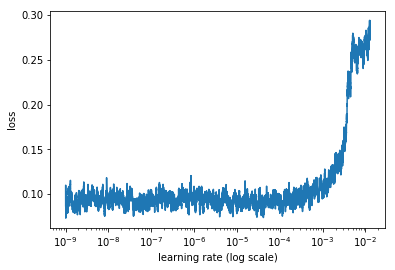

In [0]:
learn.sched.plot()